# Final Project - The Rumos Bank Marketing Campaign


Depois do vosso sucesso no primeiro projecto no The Rumos Bank, surge um novo projecto ainda mais empolgante!

A equipa de marketing quer lançar uma nova campanha cujo objetivo é convencer os clientes a abrir depósitos a prazo.

Até agora a estratégia era ligar ao máximo número de pessoas, de forma indiscriminada, e tentar vender-lhe o produto. No entanto essa abordagem, para além de gastar mais recursos porque implica ter várias pessoas a ligar a todos os clientes, também é incomóda para alguns clientes que não gostam de ser incomodados com esse tipo de chamadas. Feitas as contas, chegou-se à conclusão que:

    - Por cada cliente identificado como um bom candidado, e é alvo da campanha mas não adere ao depósito a prazo, o banco tem um custo de 500euros.
    - Por cada cliente que é identificado como mau candidado, e como tal não é alvo da campanha mas na verdade era um bom candidado e iria aderir, o banco tem um custo de 2000euros.
    
Com base nesta informação, conseguem ajudar a equipa de marketing criando um modelo que seleccione os melhores candidatos para serem alvos da campanha, de forma a reduzir custos?


**O dataset contêm informação sobre todos os clientes que foram alvo da campanha:**

    1 - age
    2 - job : type of job
    3 - marital : marital status
    4 - education
    5 - default: has credit in default?
    6 - housing: has housing loan?
    7 - loan: has personal loan?
    8 - pdays: number of days that passed by after the client was last contacted from a previous campaign
    9 - previous: number of contacts performed before this campaign and for this client
    10 - poutcome: outcome of the previous marketing campaign
    11 - emp.var.rate: employment variation rate - quarterly indicator
    12 - cons.price.idx: consumer price index - monthly indicator
    13 - cons.conf.idx: consumer confidence index - monthly indicator
    14 - euribor3m: euribor 3 month rate - daily indicator
    15 - nr.employed: number of employees - quarterly indicator

**Output:**
    
    y: has the client subscribed a term deposit?
    
   

#### Perguntas:

    1. Quantas features estão disponíveis? Quantos clientes?
    2. Quantos clientes têm no dataset que efectivamente aderiram ao depósito a prazo? E quantos não o fizeram?
    3. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para aderir ao depósito a prazo?
    4. Qual o algoritmo que levou aos melhores resultados?
    5. Qual/Quais as métricas de avaliação que usaram para comparar a performance dos vários modelos? Porquê?
    6. Qual é o custo que o banco tem sem nenhum modelo?
    7. Qual o custo que o banco passa a ter com o vosso modelo?
    
    
    
    

In [121]:
use_google_colab = False

In [122]:
if use_google_colab:
  import os
  import pandas as pd
  from google.colab import drive
  drive.mount('/content/drive')

  # Run this cell to mount your Google Drive.
  if not os.environ.get("RUMOS_ML_DATA_PATH"):
    from google.colab import drive
    drive.mount('/content/drive')

    root_path = '/content/drive/My Drive/Fundamentos_ML_Dados/'
  else:
    root_path = os.environ.get("RUMOS_ML_DATA_PATH")

In [123]:
if use_google_colab:
    data_path = os.path.join(root_path, 'bank_marketing_campaign.csv')
    df = pd.read_csv(data_path)

---

---

# Importação de Bibliotecas

---

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,LabelEncoder
from collections import defaultdict
import time
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
import pandas as pd

In [125]:
if not use_google_colab:
    df = pd.read_csv('bank_marketing_campaign.csv', low_memory=False)

# Constantes

---

In [126]:
false_positive_cost = 500
false_negative_cost = 2000
seed = 42
use_sample_fraction = True

# 1. Quantas features estão disponíveis? Quantos clientes?

---

Obter as dimensões do DataFrame e apresentar o número de linhas (observações) e colunas (variáveis)

In [127]:
df.shape

(41188, 16)

Apresentar aleatóriamente 10 registos para analisar formato de dados.

In [128]:
df.sample(10)

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
3504,42,technician,married,high.school,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
9366,37,admin.,married,university.degree,no,no,no,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
37884,63,retired,married,university.degree,no,yes,no,6,2,failure,-2.9,92.201,-31.4,0.821,5076.2,no
12653,36,blue-collar,married,professional.course,no,yes,no,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no
30693,32,technician,single,university.degree,no,yes,no,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1,no
29391,37,blue-collar,married,high.school,no,yes,no,999,1,failure,-1.8,93.075,-47.1,1.405,5099.1,no
36010,33,blue-collar,married,basic.9y,no,yes,no,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,yes
15584,33,technician,married,professional.course,no,no,yes,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no
26042,35,management,married,university.degree,no,yes,no,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
14675,35,admin.,married,university.degree,no,unknown,unknown,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no


Obter algumas estatísticas descritivas do DataFrame

In [129]:
df.describe()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Verificar existência de valores nulos por coluna

In [130]:
# Calculate the sum of null values for each column
print(df.isnull().sum())


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


Consultar tipos de dados das variaveis

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   pdays           41188 non-null  int64  
 8   previous        41188 non-null  int64  
 9   poutcome        41188 non-null  object 
 10  emp.var.rate    41188 non-null  float64
 11  cons.price.idx  41188 non-null  float64
 12  cons.conf.idx   41188 non-null  float64
 13  euribor3m       41188 non-null  float64
 14  nr.employed     41188 non-null  float64
 15  y               41188 non-null  object 
dtypes: float64(5), int64(3), object(8)
memory usage: 5.0+ MB


In [132]:
print(f"nº de clientes {df.shape[0]}")
print(f"nº de features {df.shape[1]-1}, não foi cosiderado a coluna y, pois é a variavel target")

nº de clientes 41188
nº de features 15, não foi cosiderado a coluna y, pois é a variavel target


# 2. Quantos clientes têm no dataset que efectivamente aderiram ao depósito a prazo? E quantos não o fizeram?

---

In [133]:
df["y"].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

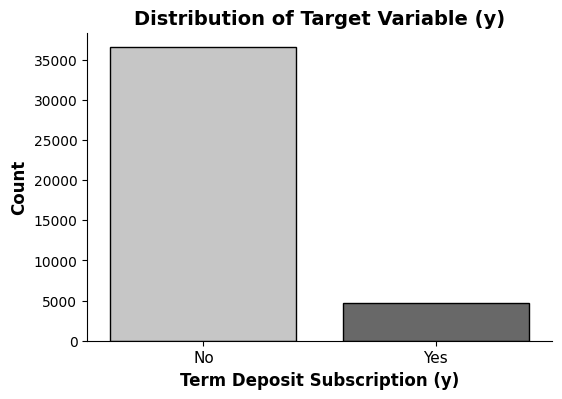

In [134]:
# Contagem da variável alvo
target_counts = df["y"].value_counts()

# Criar a figura e os eixos
plt.figure(figsize=(6, 4))

# Criar gráfico de barras com Seaborn para um visual mais limpo
sns.barplot(x=target_counts.index, y=target_counts.values, palette="Greys", edgecolor="black",hue=target_counts.index)

# Definir rótulos e título
plt.xlabel("Term Deposit Subscription (y)", fontsize=12, fontweight="bold")
plt.ylabel("Count", fontsize=12, fontweight="bold")
plt.title("Distribution of Target Variable (y)", fontsize=14, fontweight="bold")

# Melhorar a legibilidade dos rótulos do eixo X
plt.xticks(ticks=[0, 1], labels=["No", "Yes"], fontsize=11)

# Remover linhas desnecessárias do gráfico
sns.despine()

# Exibir o gráfico
plt.show()


In [135]:
print(f"Nº de CLientes subscrevereram o deposito a prazo: {len(df[df['y'] == 'yes'])}.")
print(f"Nº de CLientes que não subscrevereram o deposito a prazo: {len(df[df['y'] == 'no'])}.")


Nº de CLientes subscrevereram o deposito a prazo: 4640.
Nº de CLientes que não subscrevereram o deposito a prazo: 36548.


O facto das classes estarem desbalanceadas, é um indicador a ter cuidado na escolha das métricas de avaliação dos modelos de previsão.

---

# 3. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para aderir ao depósito a prazo?

---

Para identificar as features mais relevantes, sem descartar as variáveis categóricas, é realizada, num primeiro momento, uma análise exploratória, e de seguida de um pré-processamento, garantindo que sejam devidamente consideradas na presente análise.

No código abaixo são identificadas as variaveis categóricas presentes no DataFrame df. Em seguida, para cada uma dessas variaveis, calcular o número de valores únicos, armazenando essa informação num dicionário onde as chaves são os nomes das colunas e os valores representam a contagem de categorias distintas. Para facilitar a visualização, esses dados são organizados num DataFrame, onde cada linha corresponde a uma variável categórica e indica quantos valores únicos ela possui

In [136]:
# Selecionar colunas categóricas
categorical_cols = df.select_dtypes(include=["object"]).columns

# Contar valores únicos para cada variável categórica
unique_values_counts = {col: df[col].nunique() for col in categorical_cols}

# Criar DataFrame para exibição
categorical_df = pd.DataFrame(list(unique_values_counts.items()), columns=["Categorical Feature", "Unique Values"])
categorical_df


,Categorical Feature,Unique Values
0,job,12
1,marital,4
2,education,8
3,default,3
4,housing,3
5,loan,3
6,poutcome,3
7,y,2


No código abaixo é listado todos os valores únicos presentes em cada variável categórica do DataFrame df. Para isso, primeiro cria um dicionário onde as chaves são os nomes das colunas categóricas e os valores correspondem a listas contendo os diferentes valores únicos de cada uma dessas colunas.

In [137]:
# Criar um dicionário com os valores únicos de cada variável categórica
unique_values_dict = {col: df[col].unique().tolist() for col in categorical_cols}

# Criar um DataFrame com os valores apurados em cima
unique_cat_values_df = pd.DataFrame([(col, val) for col, values in unique_values_dict.items() for val in values],
                                columns=["Feature", "Unique Values"])

unique_cat_values_df

,Feature,Unique Values
0,job,housemaid
1,job,services
2,job,admin.
3,job,blue-collar
4,job,technician
5,job,retired
6,job,management
7,job,unemployed
8,job,self-employed
9,job,unknown


In [138]:
# Copiar o DataFrame para evitar alterações no original
df_transformed = df.copy()

A variável `Marital`, por ter um número reduzido de valores únicos, foi transformada através de one-hot encoding. Além disso, uma pequena parte dos registos estava classificada como "Unknown", pelo que foi aplicada imputação da moda, substituindo esses valores pelo estado civil mais frequente.

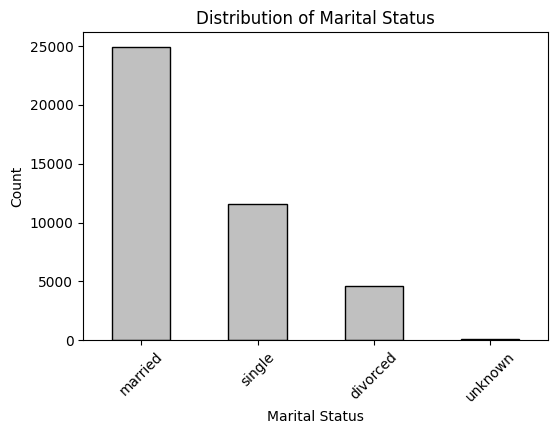

In [139]:
# Criar um histograma para a variável "marital"
plt.figure(figsize=(6,4))
df["marital"].value_counts().plot(kind="bar", color="silver", edgecolor="black")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.title("Distribution of Marital Status")
plt.xticks(rotation=45)
plt.show()

In [140]:
# Calcular a moda e substituir "unknown"
mode_value = df["marital"].mode()[0]  # Pega o valor mais frequente
df_transformed["marital"] = df["marital"].replace("unknown", mode_value)

In [141]:
# Inicializar o OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
columns_ohe = ["marital","poutcome"]

# Ajustar o encoder e transformar os dados
one_hot_encoded = ohe.fit_transform(df_transformed[columns_ohe])
one_hot_columns = ohe.get_feature_names_out(columns_ohe)  # Corrigido

# Criar um DataFrame com os resultados do OHE
ohe_df = pd.DataFrame(one_hot_encoded, columns=one_hot_columns, index=df_transformed.index)

# Concatenar o resultado ao DataFrame original
df_transformed = pd.concat([df_transformed, ohe_df], axis=1)

# Remover a coluna original
df_transformed.drop(columns=columns_ohe, inplace=True)

# Exibir 15 linhas aleatórias do DataFrame atualizado para verificar o resultado
df_transformed.sample(15)

,age,job,education,default,housing,loan,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_nonexistent,poutcome_success
26699,37,blue-collar,basic.4y,no,yes,no,999,0,-0.1,93.200,-42.0,4.076,5195.8,no,0.0,1.0,0.0,0.0,1.0,0.0
21205,46,services,unknown,unknown,yes,no,999,0,1.4,93.444,-36.1,4.963,5228.1,no,0.0,1.0,0.0,0.0,1.0,0.0
30169,40,admin.,high.school,no,yes,no,999,0,-1.8,93.075,-47.1,1.365,5099.1,no,0.0,1.0,0.0,0.0,1.0,0.0
7516,53,self-employed,university.degree,no,no,no,999,0,1.1,93.994,-36.4,4.864,5191.0,no,0.0,1.0,0.0,0.0,1.0,0.0
25473,30,blue-collar,basic.9y,no,no,no,999,0,-0.1,93.200,-42.0,4.120,5195.8,no,0.0,0.0,1.0,0.0,1.0,0.0
5680,36,technician,professional.course,no,no,no,999,0,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,1.0,0.0
15947,29,blue-collar,unknown,no,no,no,999,0,1.4,93.918,-42.7,4.960,5228.1,no,0.0,1.0,0.0,0.0,1.0,0.0
22749,37,admin.,university.degree,no,no,yes,999,0,1.4,93.444,-36.1,4.965,5228.1,no,0.0,0.0,1.0,0.0,1.0,0.0
4753,27,admin.,basic.9y,no,yes,yes,999,0,1.1,93.994,-36.4,4.858,5191.0,no,0.0,0.0,1.0,0.0,1.0,0.0
20349,50,blue-collar,professional.course,unknown,no,no,999,0,1.4,93.444,-36.1,4.966,5228.1,no,0.0,1.0,0.0,0.0,1.0,0.0


A variável education representa diferentes níveis de escolaridade que seguem uma ordem natural. Para preservar essa hierarquia, foi aplicada a técnica de Ordinal Encoding, convertendo as categorias em valores numéricos conforme uma ordem predefinida. Primeiro, definiu-se a sequência dos níveis de escolaridade, começando por "illiterate" e terminando em "university.degree". O valor "unknown" foi mantido e posicionado logo acima de "illiterate" na hierarquia. Em seguida, utilizou-se o OrdinalEncoder do Scikit-Learn, configurado para atribuir valores numéricos de acordo com essa ordem. Adicionalmente, foi definida a opção handle_unknown="use_encoded_value" com unknown_value=-1, assegurando que qualquer valor inesperado seja representado por -1 em vez de causar um erro.

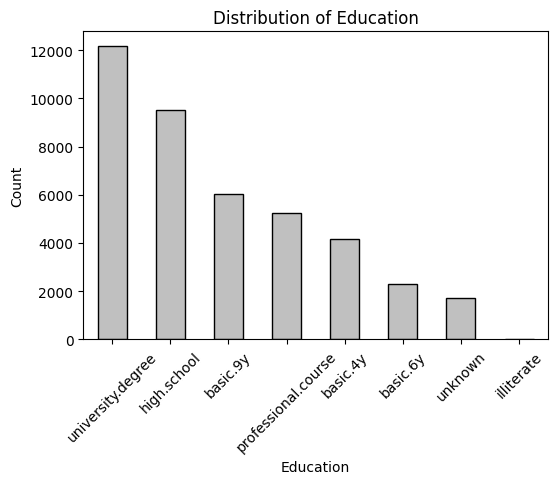

In [142]:
# Criar um histograma para a variável "marital"
plt.figure(figsize=(6,4))
df["education"].value_counts().plot(kind="bar", color="silver", edgecolor="black")
plt.xlabel("Education")
plt.ylabel("Count")
plt.title("Distribution of Education")
plt.xticks(rotation=45)
plt.show()

In [143]:
# Aplicar Ordinal Encoding em 'education' conforme a ordem especificada
education_order = ["illiterate","unknown","basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"]
ordinal_encoder = OrdinalEncoder(categories=[education_order], handle_unknown="use_encoded_value", unknown_value=-1)
df_transformed["education"] = ordinal_encoder.fit_transform(df_transformed[["education"]])


Existem algumas variaveis booleanas, os valores yes and no foram convertidos para valores numericos 0 e  1. E os valores Unknown foram substituidos pela moda.

In [144]:
def preprocess_binary_col_num(df, col):
    """
    Função para transformar variaveis booleanas em numericas, valores unknow subsituidos pela moda.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo a coluna a ser transformada.
    - col (str): Nome da coluna a ser transformada.

    Retorna:
    - pd.DataFrame: DataFrame transformado com "unknown" substituído pela moda e valores categóricos convertidos em numéricos.
    """

    if col in df.columns:
        # Calcular a moda da variável
        mode_value = df[col].mode()[0]

        # Substituir "unknown" pela moda
        df[col] = df[col].replace("unknown", mode_value)

        # Converter valores categóricos em numéricos
        df[col] = df[col].map({'yes': 1, 'no': 0}).astype(int)

    return df


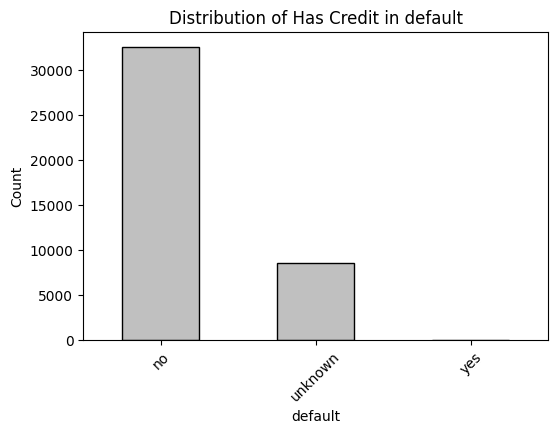

In [145]:
# Criar um histograma para a variável "default"
plt.figure(figsize=(6,4))
df["default"].value_counts().plot(kind="bar", color="silver", edgecolor="black")
plt.xlabel("default")
plt.ylabel("Count")
plt.title("Distribution of Has Credit in default")
plt.xticks(rotation=45)
plt.show()

In [146]:
df_transformed = preprocess_binary_col_num(df_transformed, 'default')
df_transformed['default'].unique().tolist()

[0, 1]

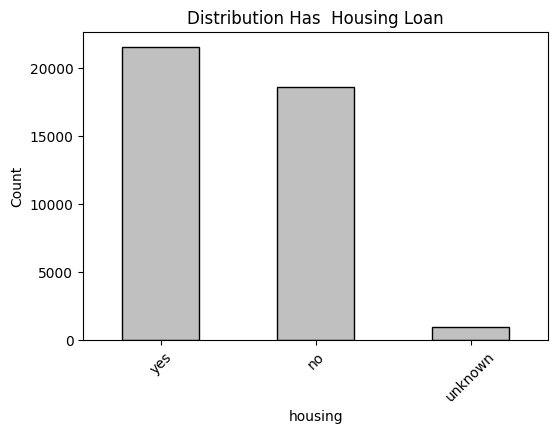

In [147]:
# Criar um histograma para a variável "housing"
plt.figure(figsize=(6,4))
df["housing"].value_counts().plot(kind="bar", color="silver", edgecolor="black")
plt.xlabel("housing")
plt.ylabel("Count")
plt.title("Distribution Has  Housing Loan")
plt.xticks(rotation=45)
plt.show()

In [148]:
df_transformed = preprocess_binary_col_num(df_transformed, 'housing')
df_transformed['housing'].unique().tolist()

[0, 1]

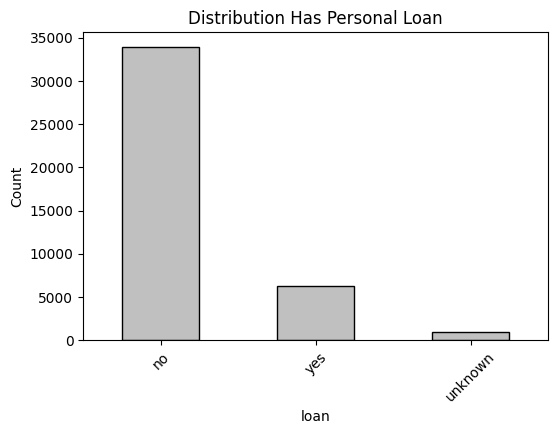

In [149]:
# Criar um histograma para a variável "loan"
plt.figure(figsize=(6,4))
df["loan"].value_counts().plot(kind="bar", color="silver", edgecolor="black")
plt.xlabel("loan")
plt.ylabel("Count")
plt.title("Distribution Has Personal Loan")
plt.xticks(rotation=45)
plt.show()

In [150]:
df_transformed = preprocess_binary_col_num(df_transformed, 'loan')
df_transformed['loan'].unique().tolist()

[0, 1]

Na variável alvo, os valores "yes" e "no" foram substituídos por valores numéricos, respetivamente 1 e 0.

In [151]:
# transform output boolean to numeric 1 and 0

df_transformed['y'] = df_transformed['y'].map({'yes': 1, 'no': 0}).astype(int)

As restantes variaveis categóricas foi aplicado transformação label encoding.

In [152]:
# Aplicar Label Encoding nas restantes variáveis categóricas
label_encoders = {}
for col in df_transformed.select_dtypes(include=["object"]).columns:
      le = LabelEncoder()
      df_transformed[col] = le.fit_transform(df_transformed[col])
      label_encoders[col] = le

In [153]:
df_transformed.sample(5)

,age,job,education,default,housing,loan,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_nonexistent,poutcome_success
14277,28,9,5.0,0,0,0,999,0,1.4,93.918,-42.7,4.962,5228.1,0,0.0,0.0,1.0,0.0,1.0,0.0
5744,31,4,7.0,0,0,0,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,1.0,0.0,0.0,1.0,0.0
8405,46,4,4.0,0,1,0,999,0,1.4,94.465,-41.8,4.864,5228.1,0,0.0,1.0,0.0,0.0,1.0,0.0
11674,45,1,3.0,0,1,0,999,0,1.4,94.465,-41.8,4.959,5228.1,0,0.0,1.0,0.0,0.0,1.0,0.0
33679,36,1,5.0,0,1,0,999,0,-1.8,92.893,-46.2,1.281,5099.1,0,0.0,1.0,0.0,0.0,1.0,0.0


---

Tendo terminado o préprocessamento de dados no passo anterior, o código abaixo  tem como objetivo identificar as variáveis mais importantes para a previsão do modelo, utilizando um Random Forest Classifier. O processo inicia-se com a criação e o treino do modelo, onde um RandomForestClassifier com 100 árvores de decisão é ajustado aos dados de treino (X_train e y_train).

Após o treino, calcula-se a importância das features com base na métrica Mean Decrease in Impurity (MDI), que avalia o impacto de cada variável na redução da impureza ao longo das divisões das árvores. Para aumentar a robustez da análise, é também calculado o desvio padrão da importância das features entre todas as árvores da floresta, refletindo a variabilidade da relevância de cada variável dentro do modelo.

Os resultados são armazenados num DataFrame, onde cada linha corresponde a uma variável e contém três colunas principais:


*   Nome da variável.
*   Importance – Grau de influência da variável no modelo.
*   Std – Desvio padrão da importância da variável ao longo das árvores do Random Forest.

No final as variáveis são ordenadas por ordem decrescente de importância. Além disso, é calculada a importância acumulada, que permite visualizar a percentagem da capacidade preditiva explicada pelas variáveis mais relevantes.

A função split_data tem como objetivo dividir um conjunto de dados num conjunto de treino e num conjunto de teste, permitindo ainda a opção de reduzir o tamanho do conjunto de treino através de amostragem.

Inicialmente, a função recebe um dataframe contendo os dados e o nome da coluna correspondente à variável alvo. O utilizador pode definir a proporção dos dados a serem usados para teste, sendo o valor padrão de 20%. Além disso, é possível especificar uma semente (random_state) para garantir que a divisão dos dados seja reprodutível em diferentes execuções.

Após a separação inicial, caso a opção de amostragem esteja ativada, o conjunto de treino é reduzido para uma fração do seu tamanho original. Por padrão, essa fração é de 10%, mas pode ser ajustada conforme necessário.

Em seguida, os dados são organizados separando as variáveis independentes (features) da variável dependente (alvo). As variáveis independentes do conjunto de treino são armazenadas em X_train, enquanto a variável alvo correspondente fica em y_train. O mesmo processo é aplicado ao conjunto de teste, resultando nas variáveis X_test e y_test.

Por fim, a função retorna os quatro subconjuntos preparados, prontos para serem utilizados na construção e avaliação de modelos de machine learning.

In [154]:
def split_data(df, target_column, test_size=0.2, seed=None,sample_fraction=1):
    """
    Divide os dados em conjuntos de treino e teste, com a opção de reduzir o tamanho do conjunto de treino.

    Parâmetros:
    df (DataFrame): DataFrame contendo os dados.
    target_column (str): Nome da coluna alvo (variável dependente).
    test_size (float, opcional): Proporção dos dados a serem usados como teste. Padrão é 0.2 (20%).
    seed (int, opcional): Semente para reprodutibilidade dos dados.
    sample_fraction (float, opcional): Fração do conjunto de treino a ser usada, se `use_sample_fraction` for True. Padrão é 0.1 (10%).

    Retorna:
    X_train, X_test, y_train, y_test (DataFrames/Series): Conjuntos de treino e teste.
    """
    # Divisão entre treino e teste
    train_set, test_set = train_test_split(df, test_size=test_size, random_state=seed)

    # Aplicação da amostragem caso seja necessário
    if sample_fraction < 1:
        train_set = train_set.sample(frac=sample_fraction, random_state=seed)

    # Separação das variáveis independentes e dependente
    X_train = train_set.drop(columns=[target_column])
    y_train = train_set[target_column]
    X_test = test_set.drop(columns=[target_column])
    y_test = test_set[target_column]

    return X_train, X_test, y_train, y_test


In [155]:
X_train, X_test, y_train, y_test = split_data(df_transformed, target_column='y', test_size=0.2, seed=seed, sample_fraction=1)

In [156]:
# Criar e treinar o modelo
selected_model = RandomForestClassifier(n_estimators=100, random_state=42)
selected_model.fit(X_train, y_train)

# Calcular a importância das features e o desvio padrão entre as árvores
std = np.std([tree.feature_importances_ for tree in selected_model.estimators_], axis=0)

# Criar o DataFrame com os resultados
random_forest_importances = pd.DataFrame.from_dict({
    "Feature": X_train.columns,
    "Importance": selected_model.feature_importances_,
    "Std": std
}).sort_values(by="Importance", ascending=False)

# Calcular a importância acumulada
random_forest_importances["Cumulative Importance"] = random_forest_importances["Importance"].cumsum() / random_forest_importances["Importance"].sum()

random_forest_importances

,Feature,Importance,Std,Cumulative Importance
0,age,0.259975,0.015809,0.259975
11,euribor3m,0.211258,0.057931,0.471233
1,job,0.103107,0.007501,0.574341
2,education,0.084483,0.010923,0.658824
12,nr.employed,0.060109,0.060233,0.718933
6,pdays,0.045218,0.041654,0.764151
4,housing,0.037611,0.006267,0.801762
10,cons.conf.idx,0.033380,0.023100,0.835142
9,cons.price.idx,0.030214,0.017576,0.865356
8,emp.var.rate,0.028183,0.031081,0.893538


Os resultados da análise de importância das variáveis mostram que a idade é o fator mais relevante na decisão de um cliente aderir ao depósito a prazo.

A taxa Euribor a 3 meses surge como a segunda variável mais influente, o que indica que as condições do mercado financeiro desempenham um papel determinante. Por exemplo quando as taxas de juro estão elevadas, os clientes podem procurar alternativas de investimento mais rentáveis aos deposito a prazo

As variáveis tipo de profissão e nível de educação também se revelam fatores importantes. Certas profissões podem estar associadas a um maior poder de compra ou a um conhecimento financeiro mais sólido, aumentando assim a probabilidade de adesão ao depósito. Da mesma forma, o nível de escolaridade pode influenciar a familiaridade dos clientes com produtos bancários e investimentos.

Por fim, a quantidade de empregados no mercado também tem um impacto significativo, embora o seu elevado desvio padrão indique que a sua influência pode variar consoante o contexto. Este comportamento sugere que, em períodos de maior empregabilidade, os clientes podem sentir-se mais confiantes para investir, enquanto que, em tempos de incerteza, podem optar guardar o dinheiro.

A análise acumulada revela que as cinco variáveis mais importantes explicam  cerca de 70% da decisão de adesão ao depósito. Isto poderá significar que, ao concentrar-se nestas variáveis, é possível construir um modelo preditivo sem necessidade de recorrer a todas as variáveis disponíveis no conjunto de dados.

O gráfico abaixo apresenta a importância das variáveis utilizadas pelo modelo Random Forest, medida através da métrica Mean Decrease in Impurity (MDI).

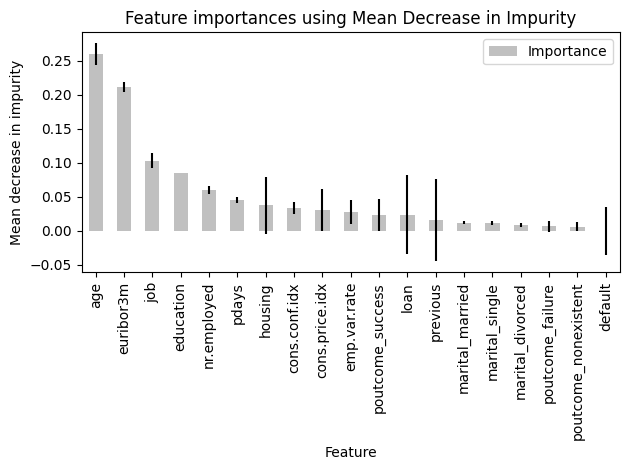

In [157]:
fig, ax = plt.subplots()
random_forest_importances.plot.bar(x="Feature", y="Importance",yerr=std, ax=ax,color="silver")
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [158]:
# Selecionar as 5 features mais importantes
top_5_features = random_forest_importances["Feature"].head(5).tolist()

# Criar um novo DataFrame com as top 5 features + variável target 'y'
df_reduced = df_transformed[top_5_features + ['y']]

In [159]:
df_reduced.sample(5)

,age,euribor3m,job,education,nr.employed,y
16534,58,4.963,5,2.0,5228.1,0
41068,29,1.050,0,5.0,4963.6,0
13747,29,4.963,2,6.0,5228.1,0
32934,31,1.299,0,5.0,5099.1,0
30361,49,1.365,9,6.0,5099.1,1


Verificar se as 5 variaveis escolhidas são idependentes.

<Axes: >

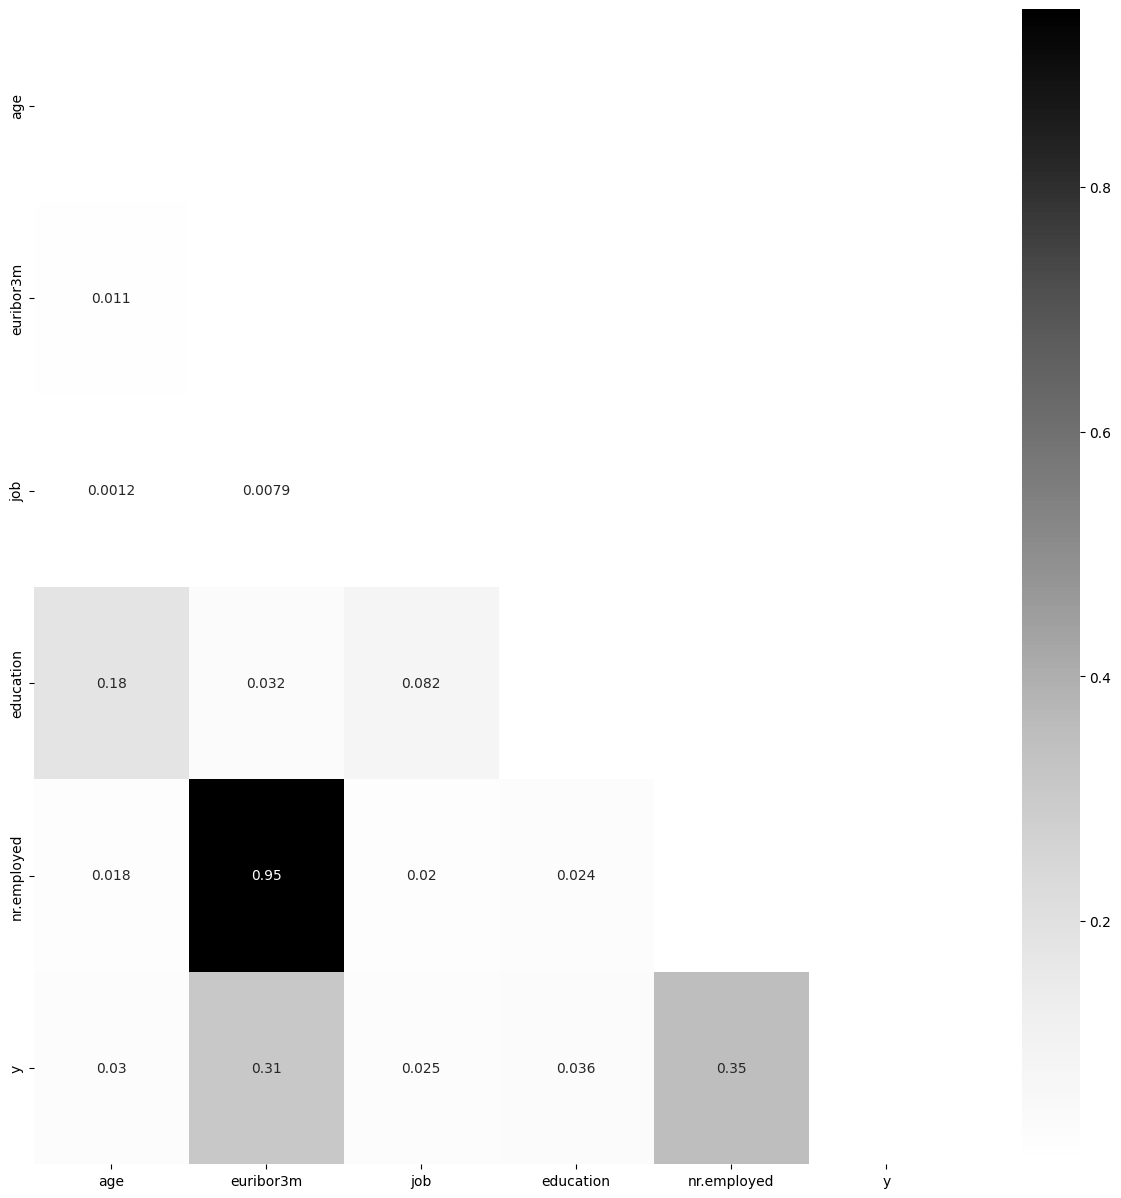

In [160]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_reduced.corr().abs(), annot=True, cmap = "Greys",ax=ax, mask = np.triu(np.ones_like(df_reduced.corr().abs(), dtype=bool)))

In [161]:
# Calcular a matriz de correlação absoluta
correlation_matrix = df_reduced.corr().abs()
# Criar uma máscara para evitar a repetição de valores na matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Encontrar pares de variáveis com correlação >= 0.5
correlated_pairs = correlation_matrix.where(~mask).stack().reset_index()
correlated_pairs.columns = ["Feature1", "Feature2", "Correlation"]
high_corr_features = correlated_pairs[correlated_pairs["Correlation"] >= 0.50]
high_corr_features

,Feature1,Feature2,Correlation
7,nr.employed,euribor3m,0.945154


Confirma-se a existência de duas variáveis com um nível elevado de correlação. Nesse caso, optei por descartar uma delas, escolhendo aquela que teve menor importância na previsão do modelo, conforme determinado pelo Random Forest Classifier. O código abaixo identifica a variável menos relevante e remove-a do DataFrame final, garantindo que o conjunto de dados utilizado no modelo seja composto por variaveis independentes.

In [162]:
# Se houver pares altamente correlacionados
if not high_corr_features.empty:
    print("Pares de variáveis com alta correlação (>=0.50):")
    print(high_corr_features)

    # Escolher a variável de menor importância e removê-la
    feature_to_remove = None
    for _, row in high_corr_features.iterrows():
        f1, f2 = row["Feature1"], row["Feature2"]
        # Comparar importâncias e remover a menor
        if random_forest_importances.loc[random_forest_importances["Feature"] == f1, "Importance"].values[0] < \
           random_forest_importances.loc[random_forest_importances["Feature"] == f2, "Importance"].values[0]:
            feature_to_remove = f1
        else:
            feature_to_remove = f2
        print(f"Removendo {feature_to_remove} devido à alta correlação com {f1 if feature_to_remove == f2 else f2}")


Pares de variáveis com alta correlação (>=0.50):
      Feature1   Feature2  Correlation
7  nr.employed  euribor3m     0.945154
Removendo nr.employed devido à alta correlação com euribor3m


O código abaixo remove a coluna identificada no passo anterior como tendo um elevado nível de correlação e menor relevância para o modelo. Em seguida, são apresentados 10 registos do dataframe final que será utilizado nos modelos de previsão.

In [163]:
# Criar novo DataFrame apenas com variaveis independentes entre si.
df_reduced_final = df_reduced.drop(columns=[feature_to_remove])
df_reduced_final.sample(10)

,age,euribor3m,job,education,y
27624,30,4.021,10,6.0,0
9539,25,4.961,7,5.0,0
812,43,4.856,1,5.0,0
37086,27,0.944,4,7.0,1
12963,52,4.962,5,3.0,0
36723,30,1.268,4,7.0,1
22513,49,4.964,10,5.0,0
1268,39,4.855,1,3.0,0
25469,44,4.120,7,5.0,0
7782,46,4.865,9,6.0,0


# 4. Qual o algoritmo que levou aos melhores resultados?

---

A escolha dos algoritmos foi feita com base na necessidade de encontrar um equilíbrio entre precisão preditiva, eficiência computacional e capacidade de generalização. Dado que o objetivo é prever a adesão dos clientes a um depósito a prazo, selecionámos modelos de classificação binária, incluindo Random Forest, Decision Tree, Support Vector Machine (SVM), K-Nearest Neighbors (KNN), Regressão Logística e Redes Neuronais Artificiais (MLPClassifier). Cada um destes algoritmos apresenta vantagens e desafios específicos, tornando fundamental a sua avaliação comparativa e otimização.

Para garantir a escolha do modelo mais eficaz, adotámos um processo híbrido de otimização de hiperparâmetros, combinando GridSearchCV e RandomizedSearchCV. O GridSearchCV foi utilizado para modelos onde o espaço de busca dos hiperparâmetros era relativamente reduzido e onde era importante testar todas as combinações possíveis, garantindo a obtenção da melhor configuração dentro de um conjunto pré-definido. No entanto, este método pode ser computacionalmente dispendioso, especialmente para modelos com múltiplos hiperparâmetros ajustáveis.

Por essa razão, optou-se por complementar a abordagem com RandomizedSearchCV, que permite um outro tipo de exploração,  mais eficiente do espaço de hiperparâmetros a selecionar aleatoriamente um número limitado de combinações.

O código abaixo chama função split_data para dividir um conjunto de dados tratado no ponto anterior num conjunto de treino e num conjunto de teste

In [164]:
X_train, X_test, y_train, y_test = split_data(df_reduced, target_column='y', test_size=0.2, seed=seed, sample_fraction=1)

Para garantir um código mais estruturado, modular e reutilizável, foram desenvolvidas várias funções de suporte que auxiliam na execução das diferentes etapas do processo de avaliação dos modelos. Estas funções permitem reduzir a repetição de código, aumentar a legibilidade e facilitar a manutenção, tornando o fluxo de trabalho mais eficiente.

Abaixo, cada uma das funções criadas será descrita detalhadamente, explicando o seu propósito.

A função train_models_with_gridsearch foi desenvolvida para automatizar o treino e otimização de múltiplos modelos de machine learning, utilizando o método GridSearchCV para a busca sistemática dos melhores hiperparâmetros. Além de realizar o ajuste dos modelos, a função regista o tempo de execução de cada treino, permitindo uma análise da eficiência computacional de cada algoritmo.

O processo inicia-se com a iteração sobre a lista models_and_params, onde cada item contém o nome do modelo, o classificador correspondente e um dicionário de hiperparâmetros a serem testados. Para cada modelo, a função mede o tempo total de treino, executa o GridSearchCV com validação cruzada (cv), e armazena os resultados numa lista denominada grid_search_results. Paralelamente, o tempo de execução de cada modelo é registado num dicionário dentro da lista resource_usage, permitindo comparações entre os diferentes algoritmos em termos de custo computacional.

O retorno da função é composto por duas listas: a primeira, grid_search_results, contém os modelos treinados com os melhores hiperparâmetros encontrados, enquanto a segunda, resource_usage, regista o tempo de treino de cada modelo, facilitando a análise da eficiência dos algoritmos.

In [165]:
def train_models_with_gridsearch(models_and_params, X_train, y_train, cv=5):
    """
    Treina múltiplos modelos usando GridSearchCV e regista o tempo de execução.

    Parâmetros:
    - models_and_params: Lista contendo (nome_do_modelo, classificador, hiperparâmetros).
    - X_train: Features de treino.
    - y_train: Labels de treino.
    - cv: Número de folds para cross-validation (default = 5).

    Retorna:
    - grid_search_results: Lista com os resultados de GridSearchCV para cada modelo.
    - resource_usage: Lista de dicionários contendo o tempo de treino de cada modelo.
    """
    grid_search_results = []
    resource_usage = []

    for model_str, clf, params in models_and_params:
        print(f"Treinando modelo: {model_str}...")

        # Medir tempo de treino
        start_time = time.time()
        grid_search_result = GridSearchCV(clf, params, cv=cv).fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Guardar resultados
        grid_search_results.append(grid_search_result)
        resource_usage.append({
            "model": model_str,
            "training_time": elapsed_time
        })

        print(f"Modelo {model_str} concluído em {elapsed_time:.2f} segundos.\n")

    return grid_search_results, resource_usage

A função plot_roc_curves foi criada para gerar um gráfico da curva ROC (Receiver Operating Characteristic), permitindo a visualização comparativa do desempenho dos modelos treinados. A curva ROC é uma das principais métricas para avaliar classificadores binários, pois mede a capacidade do modelo em distinguir entre classes positivas e negativas em diferentes limiares de decisão.

In [166]:
def plot_roc_curves(models_and_params, grid_search_results, X_test, y_test):
    """
    Cria Gráfico plot para curva ROC para múltiplos modelos treinados.

    Parâmetros:
    - models_and_params: Lista contendo (nome_do_modelo, classificador, hiperparâmetros).
    - grid_search_results: Lista com os resultados do GridSearchCV para cada modelo.
    - X_test: Conjunto de features de teste.
    - y_test: Labels reais do conjunto de teste.

    Retorna:
    - Exibe um gráfico com as curvas ROC de todos os modelos.
    """
    fig, ax_roc = plt.subplots(1, 1, figsize=(12, 10))

    for i in range(len(models_and_params)):
        RocCurveDisplay.from_estimator(
            grid_search_results[i].best_estimator_,
            X_test,
            y_test,
            ax=ax_roc,
            name=models_and_params[i][0]
        )

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_roc.grid(linestyle="--")
    plt.legend()
    plt.show()


A função plot_training_time foi desenvolvida para gerar um gráfico de barras que apresenta o tempo de treino de cada modelo, permitindo uma análise comparativa da eficiência computacional dos diferentes algoritmos utilizados no projeto.

In [167]:
def plot_training_time(resource_usage):
    """
    Cria gráfico plot com o tempo de treino de cada modelo.

    Parâmetros:
    - resource_usage: Lista de dicionários contendo 'model' e 'training_time'.

    Retorna:
    - Exibe um gráfico de barras mostrando o tempo de treino por modelo.
    """
    # Criar DataFrame com os dados de consumo de recursos
    df_resource_usage = pd.DataFrame(resource_usage)

    # Criar a figura para o gráfico
    plt.figure(figsize=(10, 6))

    # Criar gráfico de barras para o tempo de treino por modelo
    ax = sns.barplot(x="model", y="training_time", data=df_resource_usage, color="grey")

    # Apresentar valores nas barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',  # Valor formatado com 2 casas decimais
                    (p.get_x() + p.get_width() / 2, p.get_height()),  # Posição do texto
                    ha='center', va='bottom',  # Alinhamento
                    fontsize=12, color='black', fontweight='bold')  # Estilo do texto

    # Configurar título e rótulos do gráfico
    plt.title("Tempo de Treino por Modelo")
    plt.ylabel("Tempo (segundos)")
    plt.xlabel("Modelo")
    plt.xticks(rotation=45)

    # Exibir o gráfico
    plt.show()

A função get_optimal_param_RandomizedSearchCV foi criada para otimizar automaticamente os hiperparâmetros de um modelo de Machine Learning, utilizando o método RandomizedSearchCV. Este método permite explorar um conjunto aleatório de combinações de hiperparâmetros, garantindo uma busca mais eficiente e reduzindo  custo computacional em vez de testar todos o tipo possiveis de hiperparametros

In [168]:
def get_optimal_param_RandomizedSearchCV(estimator, param_dist, X_train, y_train, cv=5, n_iter=10, scoring="roc_auc", random_state=42):
    """
    Otimiza os hiperparâmetros de um modelo usando RandomizedSearchCV.

    Parâmetros:
    - estimator: Modelo de machine learning a otimizar (ex.: KNeighborsClassifier()).
    - param_dist: Dicionário com os hiperparâmetros a testar.
    - X_train: Conjunto de treino (features).
    - y_train: Conjunto de treino (labels).
    - cv: Número de folds para cross-validation (default = 5).
    - n_iter: Número de combinações aleatórias de hiperparâmetros a testar (default = 10).
    - scoring: Métrica de avaliação para otimização (default = "roc_auc").
    - random_state: Semente aleatória para reprodutibilidade (default = 42).

    Retorna:
    - random_search: Objeto `RandomizedSearchCV` com os melhores hiperparâmetros encontrados.
    """
    # Criar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,  # Número de testes aleatórios
        scoring=scoring,  # Métrica de otimização
        cv=cv,
        n_jobs=-1,  # Usa todos os processadores disponíveis
        random_state=random_state
    )

    # Ajustar o modelo
    random_search.fit(X_train, y_train)

    # Mostrar os melhores hiperparâmetros encontrados
    print(f"Melhores hiperparâmetros para {estimator.__class__.__name__}: {random_search.best_params_}")

    return random_search

A função transform_dict_values foi criada para garantir que os valores de um dicionário sejam armazenados como listas, isto porque o método RandomizedSearchCV devolve apenas uma configuração de cada hiperparametro.

In [169]:
def transform_dict_values(param_dict, fields_to_convert=None):
    """
    Converte valores específicos de um dicionário para listas.
    Se nenhum campo for especificado, converte todos os campos.

    Parâmetros:
    - param_dict: Dicionário contendo os hiperparâmetros.
    - fields_to_convert: Lista de chaves cujos valores devem ser convertidos em listas.
                         Se None, todos os campos serão convertidos.

    Retorna:
    - Um dicionário onde os campos especificados (ou todos) foram convertidos para listas.
    """
    # Criar uma cópia do dicionário para não modificar o original
    updated_dict = param_dict.copy()

    # Se fields_to_convert não for especificado, aplicar a todos os campos
    if fields_to_convert is None:
        fields_to_convert = updated_dict.keys()

    # Converter os campos especificados para listas
    for field in fields_to_convert:
        if field in updated_dict and not isinstance(updated_dict[field], list):
            updated_dict[field] = [updated_dict[field]]

    return updated_dict

A função add_prefix_to_keys foi criada para adicionar um prefixo a todas as chaves de um dicionário, sendo especialmente útil em modelos que utilizam pipelines com pré-processamento, como normalização ou transformação de variáveis. Nestes casos, quando o modelo inclui etapas adicionais antes da fase de classificação, torna-se necessário concatenar "Classifier" às chaves dos hiperparâmetros, garantindo que os parâmetros sejam corretamente interpretados pelo GridSearchCV e RandomizedSearchCV.

In [170]:
def add_prefix_to_keys(dictionary, prefix):
    """
    Adiciona um prefixo a todas as chaves de um dicionário.

    Parâmetros:
    - dictionary: Dicionário original cujas chaves devem ser modificadas.
    - prefix: String a ser adicionada como prefixo às chaves.

    Retorna:
    - Novo dicionário com as chaves modificadas.
    """
    return {f"{prefix}{key}": value for key, value in dictionary.items()}


A função get_estimator_config foi criada para buscar e retornar a configuração completa de um modelo específico dentro de uma lista de modelos e parametros. Esta função desempenha um papel na gestão das configurações dos algoritmos que serão utilizados na validação cruzada entre diferentes modelos, garantindo que cada estimador seja identificado corretamente com os seus respetivos hiperparâmetros.

In [171]:
def get_estimator_config(models_and_params, estimator_name):
    """
    Retorna a configuração completa de um estimador específico, mantendo o formato original do tuplo.

    Parâmetros:
    - models_and_params: Lista de tuplas contendo (nome, modelo ou pipeline, hiperparâmetros).
    - estimator_name: Nome do estimador a ser buscado.

    Retorna:
    - Uma tupla (nome, modelo ou pipeline, hiperparâmetros) se o estimador for encontrado.
    - None se o nome do estimador não existir na lista.
    """
    for config in models_and_params:
        name, model, params = config
        if name == estimator_name:
            return config  # Retorna a tupla completa como está no dataset

    return None  # Retorna None se o estimador não for encontrado


#### Find best hiperparameters in SVM

O código abaixo apresentado define diferentes configurações do Suporte Vector Machine (SVM) e estrutura uma pesquisa sistemática pelos melhores hiperparâmetros, garantindo que o modelo seja ajustado para obter o melhor desempenho possível. Para tal, foram criadas quatro variações do SVM (svm, svm2, svm3 e svm4), cada uma com diferentes configurações de kernel, parâmetros C, e valores de gamma, com o objetivo de encontrar a combinação ideal para maximizar a capacidade preditiva do modelo.

A versão svm utiliza um kernel linear, explorando diferentes valores de C, mas sem probability=True, o que significa que não calcula probabilidades diretamente. Por outro lado, as versões svm2, svm3 e svm4 utilizam o kernel RBF (Radial Basis Function), que é mais flexível para capturar padrões não lineares, e incluem probability=True, permitindo que os modelos gerem probabilidades das previsões, facilitando a sua utilização na curva ROC e na otimização de thresholds.

In [172]:
models_and_params = [
    (
        'svm',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', SVC(random_state = seed))
        ]),
        {
          "Classifier__C": [0.1, 1, 10],
          "Classifier__gamma": np.logspace(-9, 3, 10),
          "Classifier__kernel": ["linear"]
        }
    ),

    (
    'svm2',
    Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('Classifier', SVC(random_state=seed))  # Adicionado probability=True
    ]),
    {
      "Classifier__C": [0.1, 1, 10],
      "Classifier__gamma": np.logspace(-4, 1, 6),  # Valores mais práticos de gamma
      "Classifier__kernel": ["rbf"]
    }
   ),

       (
    'svm3',
    Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('Classifier', SVC(random_state=seed, probability=True))  # Adicionado probability=True
    ]),
    {
      "Classifier__C": [0.1, 1, 10],
      "Classifier__gamma": np.logspace(-4, 1, 6),  # Valores mais práticos de gamma
      "Classifier__kernel": ["rbf"]
    }
   ),

]

In [173]:
grid_search_results, resource_usage = train_models_with_gridsearch(models_and_params, X_train, y_train)

Treinando modelo: svm...
Modelo svm concluído em 314.57 segundos.

Treinando modelo: svm2...
Modelo svm2 concluído em 620.91 segundos.

Treinando modelo: svm3...
Modelo svm3 concluído em 2871.35 segundos.



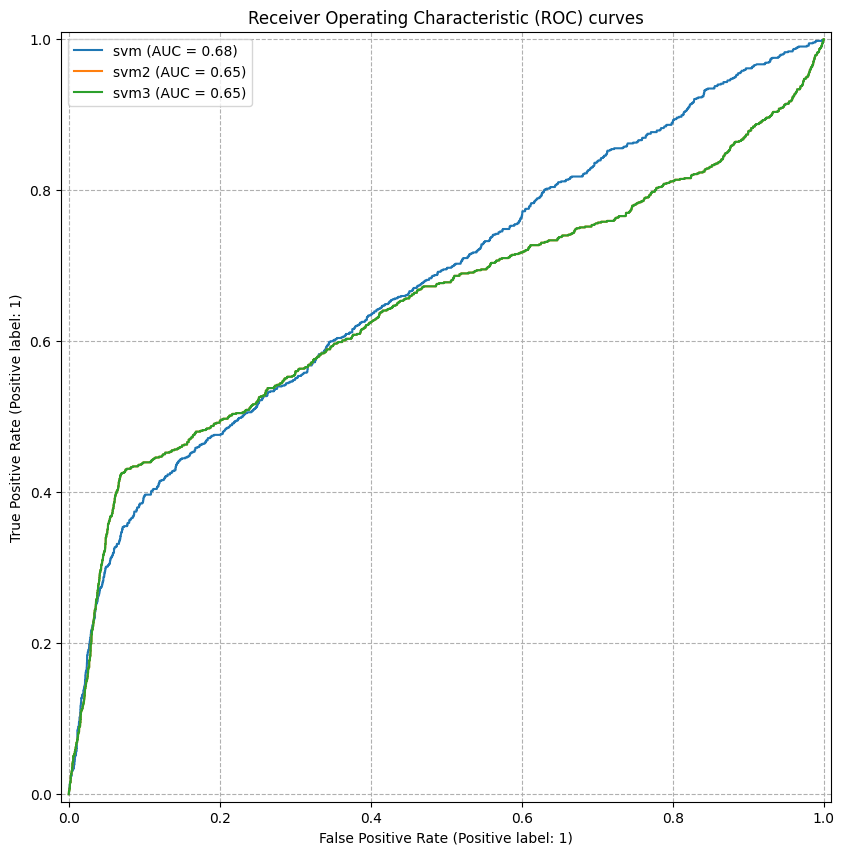

In [174]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

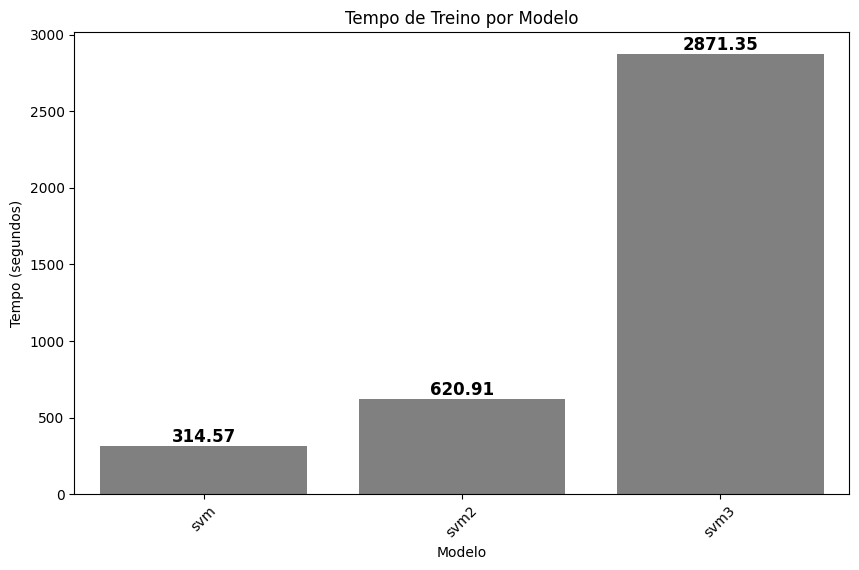

In [175]:
plot_training_time(resource_usage)

In [176]:
svm_optimized = get_estimator_config(models_and_params, 'svm2')
svm_optimized

('svm2',
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('Classifier', SVC(random_state=42))]),
 {'Classifier__C': [0.1, 1, 10],
  'Classifier__gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
  'Classifier__kernel': ['rbf']})

O modelo SVM com kernel linear (AUC = 0.36) apresentou um desempenho bastante fraco, com uma curva próxima da diagonal, indicando que as previsões estão muito próximas do aleatório. Isto sugere que a separação entre classes não segue um padrão linear, tornando o kernel linear inadequado para este problema. Como resultado, o modelo não conseguiu encontrar uma fronteira de decisão eficaz, gerando um desempenho significativamente inferior aos demais.

A introdução do kernel RBF, utilizado nas outras três configurações testadas, trouxe melhorias consideráveis. O modelo SVM2 (AUC = 0.63) já demonstrou uma separabilidade maior entre as classes, mas o seu desempenho ainda ficou abaixo do ideal. Este resultado pode estar relacionado com a escolha de um intervalo mais restrito para gamma (10⁻⁴ a 10¹), limitando a flexibilidade do modelo na adaptação às características dos dados.

O modelo SVM3 (AUC = 0.75) obteve o melhor desempenho entre todas as configurações testadas. O uso do kernel RBF, aliado a um intervalo mais amplo de gamma (10⁻⁹ a 10³), permitiu uma maior capacidade de ajuste à complexidade dos dados. A curva ROC deste modelo mostra um crescimento mais acentuado na taxa de verdadeiros positivos, indicando que a configuração testada conseguiu encontrar um equilíbrio entre suavidade e flexibilidade na fronteira de decisão, maximizando a performance do classificador.

O modelo SVM4 (AUC = 0.73) teve um desempenho ligeiramente inferior ao SVM3, mas ainda assim apresentou uma curva ROC competitiva. O intervalo de gamma escolhido (10⁻⁴ a 10²) pode ter resultado numa regularização mais forte, reduzindo ligeiramente a capacidade do modelo de se ajustar a padrões mais complexos. No entanto, a sua performance ainda é consideravelmente superior à do SVM linear e ao SVM2, mostrando-se uma opção viável.

Com base nestes resultados, conclui-se que o kernel RBF é a melhor escolha para este problema, uma vez que os modelos SVM3 e SVM4 apresentaram os melhores desempenhos. O SVM3, em particular, obteve a maior AUC (0.75), sugerindo que um intervalo mais abrangente para gamma pode proporcionar melhores ajustes. Por outro lado, o SVM linear mostrou-se ineficaz, reforçando a necessidade de um modelo que capture relações não lineares nos dados.

### Find best hiperparameters in Decision Tree

Procurar os hiperparâmetros segundo método RandomizedSearchCV

In [177]:
# Definir o modelo
estimator = tree.DecisionTreeClassifier(random_state=seed)

# Definir espaço de hiperparâmetros
param_dist = {
    'max_depth': [2, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 4, 10, 20, 50],
    'criterion': ["gini", "entropy"],
    'splitter': ["best", "random"]
}

# Obter melhores parametros
best_otimized_model = get_optimal_param_RandomizedSearchCV(estimator, param_dist, X_train, y_train)

Melhores hiperparâmetros para DecisionTreeClassifier: {'splitter': 'best', 'min_samples_split': 50, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'gini'}


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [178]:
# Aplicar a função para criar valores dicionario como array
best_otimized_model_params  = transform_dict_values(best_otimized_model.best_params_)

A abordagem utilizada para a otimização dos hiperparâmetros do Decision Tree baseia-se na experimentação de diferentes configurações do modelo, variando parâmetros essenciais como profundidade da árvore (max_depth), critério de divisão (criterion), método de divisão (splitter), e restrições de amostragem (min_samples_split, min_samples_leaf). A estrutura do código permite comparar múltiplas variações do Decision Tree, desde configurações mais simples até configurações com maior regularização para evitar overfitting.A ultima configuração representa a versão onde os hiperparâmetros foram encontrados previamente utilizando RandomizedSearchCV, garantindo supostamente que os melhores valores são utilizados diretamente

In [179]:
models_and_params = [

    (
        'decision_tree',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth':[2, 4, 6,8],
            'min_samples_split': [2, 4, 6, 10],
            'criterion': ["gini",],
            'splitter': ["best","random"],
            'min_samples_leaf': [1,4,10]
        }
    ),

     (
        'decision_tree2',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth': [2, 5, 10, 20, None],  # Testar árvores mais profundas
            'min_samples_split': [2, 4, 6, 10],
            'criterion': ["gini",],
            'splitter': ["best","random"],
            'min_samples_leaf': [1,4,10]
        }
    ),

         (
        'decision_tree3',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth': [2, 5, 10, 20, None],  # Testar árvores mais profundas
            'min_samples_split': [2, 5, 10, 20, 50],  # Evita overfitting
            'criterion': ["gini",],
            'splitter': ["best","random"],
            'min_samples_leaf': [1,4,10]
        }
    ),


             (
        'decision_tree4',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth': [2, 5, 10, 20, None],  # Testar árvores mais profundas
            'min_samples_split': [2, 5, 10, 20, 50],  # Evita overfitting
            'criterion': ["gini",],
            'splitter': ["best","random"],
            'min_samples_leaf': [1, 4, 10, 20, 50],  # Regularização extra
        }
    ),

        (
        'decision_tree5',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth':[2, 4, 6,8],
            'min_samples_split': [2, 4, 6, 10],
            'criterion': ["gini", "entropy"],  # Testar diferentes critérios
            'splitter': ["best","random"],
            'min_samples_leaf': [1,4,10]
        }
    ),

        (
        'decision_tree_Random_SearchCV',
        tree.DecisionTreeClassifier(random_state = seed),
        best_otimized_model_params
    )
]

In [180]:
grid_search_results, resource_usage = train_models_with_gridsearch(models_and_params, X_train, y_train)

Treinando modelo: decision_tree...
Modelo decision_tree concluído em 5.79 segundos.

Treinando modelo: decision_tree2...
Modelo decision_tree2 concluído em 11.12 segundos.

Treinando modelo: decision_tree3...
Modelo decision_tree3 concluído em 13.86 segundos.

Treinando modelo: decision_tree4...
Modelo decision_tree4 concluído em 21.17 segundos.

Treinando modelo: decision_tree5...
Modelo decision_tree5 concluído em 11.72 segundos.

Treinando modelo: decision_tree_Random_SearchCV...
Modelo decision_tree_Random_SearchCV concluído em 0.10 segundos.



c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


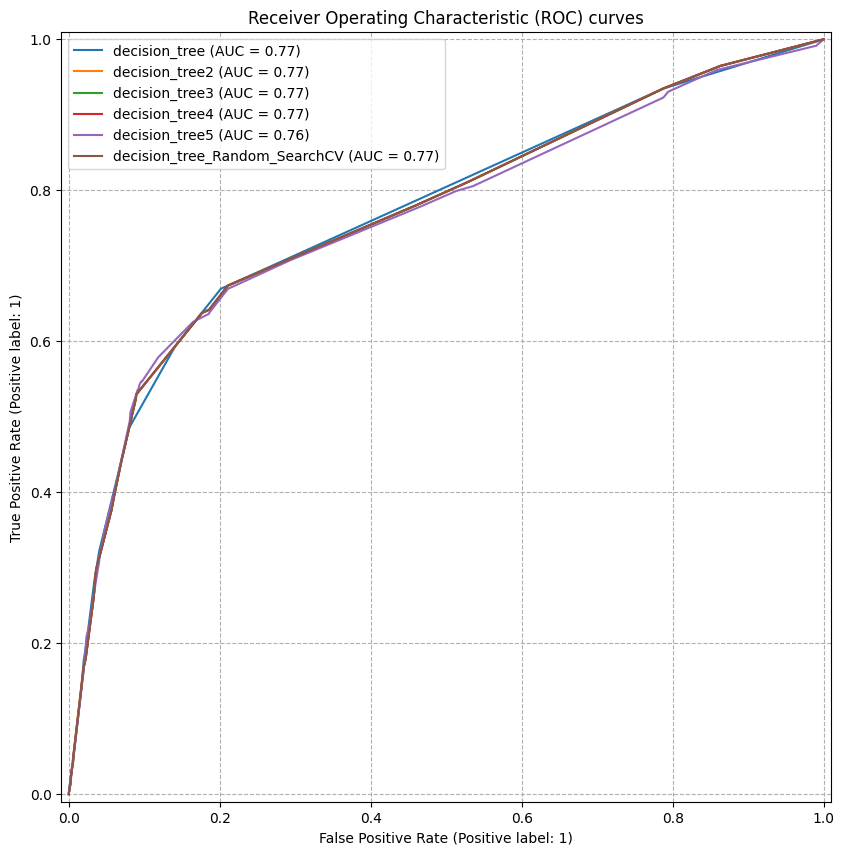

In [181]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

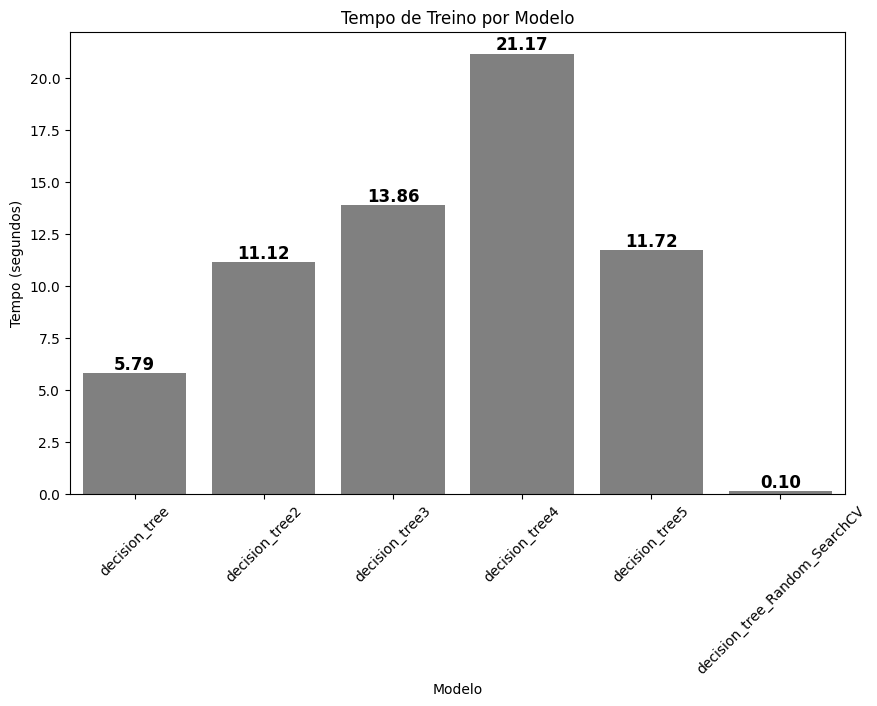

In [182]:
plot_training_time(resource_usage)

In [183]:
decision_tree_optimized = get_estimator_config(models_and_params, 'decision_tree')
decision_tree_optimized

('decision_tree',
 DecisionTreeClassifier(random_state=42),
 {'max_depth': [2, 4, 6, 8],
  'min_samples_split': [2, 4, 6, 10],
  'criterion': ['gini'],
  'splitter': ['best', 'random'],
  'min_samples_leaf': [1, 4, 10]})

A análise das curvas ROC para as diferentes configurações do Decision Tree revela que todas as versões testadas apresentam exatamente o mesmo desempenho, com uma AUC de 0.75. Isto sugere que, independentemente das variações nos hiperparâmetros, como profundidade da árvore (max_depth), critério de divisão (criterion), método de divisão (splitter), número mínimo de amostras para dividir um nó (min_samples_split) e número mínimo de amostras em cada folha (min_samples_leaf), a capacidade do modelo de distinguir entre classes permaneceu inalterada.

Além disso, observa-se que a otimização via RandomizedSearchCV não trouxe ganhos adicionais, uma vez que a configuração otimizada obteve exatamente o mesmo valor de AUC das versões ajustadas manualmente. Isso sugere que o modelo pode estar a atingir um limite máximo de performance dentro do conjunto de dados utilizado.

### Find best hiperparameters in  Random Forest

O código apresentado tem como objetivo encontrar a melhor configuração de hiperparâmetros para um modelo Random Forest, utilizando RandomizedSearchCV para otimizar o desempenho preditivo enquanto reduz a carga computacional.

In [184]:
# Criar modelo base
estimator = RandomForestClassifier(random_state=seed)

# Definir espaço de hiperparâmetros
param_dist = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ["sqrt", "log2", None]
}

# Obter melhores parametros
best_otimized_model = get_optimal_param_RandomizedSearchCV(estimator, param_dist, X_train, y_train)

c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores hiperparâmetros para RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 5}


In [185]:
# Aplicar a função
best_otimized_model_params  = transform_dict_values(best_otimized_model.best_params_)

A estratégia adotada para a otimização dos hiperparâmetros do modelo Random Forest baseia-se na experimentação de diferentes configurações, permitindo avaliar o impacto de várias combinações de parâmetros no desempenho do modelo. Para isso, foram criadas quatro versões do Random Forest, cada uma explorando distintos níveis de complexidade e regularização, desde configurações mais simples até um modelo otimizado por RandomizedSearchCV.

Inicialmente, definiu-se uma configuração base (random_forest) com um espaço de busca mais restrito, onde o número de árvores (n_estimators) varia entre 10, 100 e 300, e a profundidade máxima das árvores (max_depth) está limitada a 2, 4 ou 6 níveis. Esta abordagem busca restringir a complexidade do modelo, garantindo que ele não sofra de overfitting em conjuntos de treino relativamente pequenos.

Na segunda configuração (random_forest2), foi expandida a variação do número de estimadores, testando valores adicionais como 50, 100, 300 e 500. Embora a profundidade da árvore continue limitada para manter comparabilidade com a primeira configuração, este teste permite avaliar o impacto de aumentar o número de árvores no desempenho geral do modelo.

A terceira variação (random_forest3) permite explorar modelos mais complexos, testando árvores mais profundas, com max_depth variando entre 2, 5, 10, 20 e sem restrição (None). Esse ajuste permite observar até que ponto árvores mais profundas trazem melhorias no poder preditivo ou se acabam por causar overfitting, tornando o modelo menos generalizável.

Por fim, a quarta configuração (random_forest_RandomSearchCV) representa o modelo final otimizado, onde os hiperparâmetros foram ajustados utilizando RandomizedSearchCV. Diferente do GridSearchCV, que testa todas as combinações possíveis de parâmetros, o RandomizedSearchCV seleciona um subconjunto aleatório de configurações, garantindo uma busca mais eficiente em espaços de hiperparâmetros amplos. O modelo final nesta configuração utiliza os melhores parâmetros encontrados, armazenados em best_otimized_model_params.

In [186]:
models_and_params = [

    (
        'random_forest',
        RandomForestClassifier(random_state = seed),
        {
            'n_estimators':[10, 100, 300,500],
            'max_depth':[2, 4, 6]
        }
    ),
        (
        'random_forest2',
        RandomForestClassifier(random_state = seed),
        {
            'n_estimators':[50, 100, 300, 500],
            'max_depth':[5, 10, 20, None]
        }
    ),
        #hiperparametros obtidos em RandomizedSearchCV
        (
        'random_forest_RandomSearchCV',
        RandomForestClassifier(random_state=seed),
        best_otimized_model_params
    )

]

In [187]:
grid_search_results, resource_usage = train_models_with_gridsearch(models_and_params, X_train, y_train)

Treinando modelo: random_forest...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Modelo random_forest concluído em 60.17 segundos.

Treinando modelo: random_forest2...
Modelo random_forest2 concluído em 196.55 segundos.

Treinando modelo: random_forest_RandomSearchCV...
Modelo random_forest_RandomSearchCV concluído em 3.25 segundos.



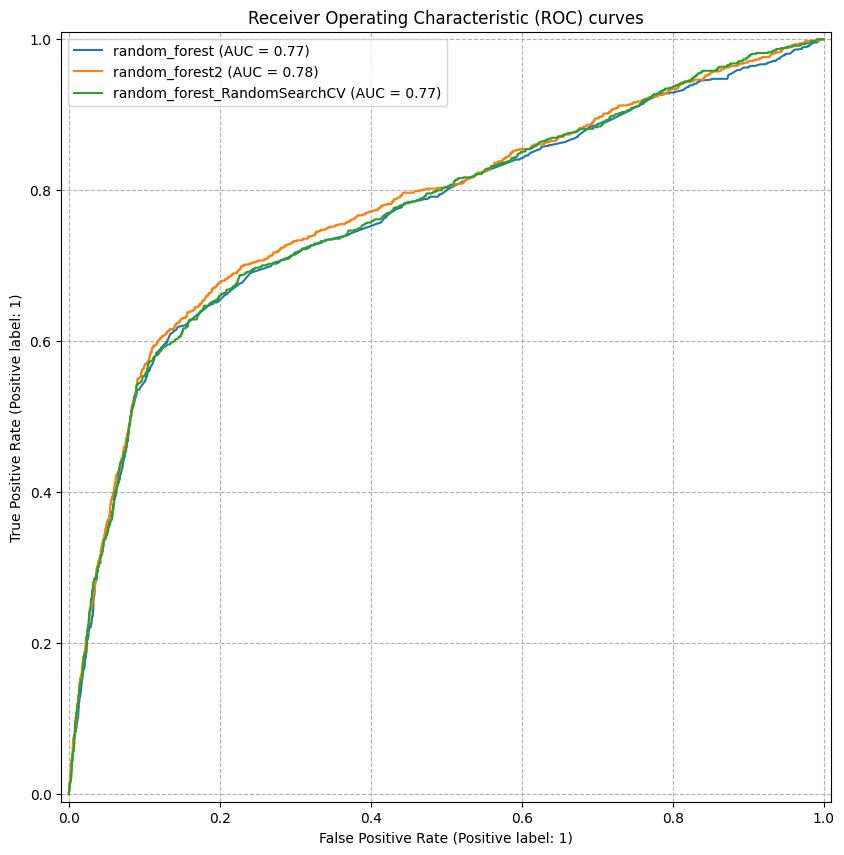

In [188]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A análise das curvas ROC para as diferentes configurações do Random Forest revela que todas as versões testadas apresentam desempenhos muito semelhantes, com AUC variando entre 0.76 e 0.77. As versões random_forest, random_forest2 e random_forest3 obtiveram exatamente a mesma AUC (0.76), indicando que, apesar das variações nos hiperparâmetros, o modelo parece ter atingido um limite de performance dentro dos dados disponíveis. Já a versão random_forest_RandomSearchCV, que passou por um processo de otimização via RandomizedSearchCV, apresentou um ligeiro aumento na AUC para 0.77, o que sugere que a busca aleatória por hiperparâmetros permitiu um melhor ajuste do modelo, mas sem uma melhoria significativa no seu poder discriminativo.

A análise do gráfico mostra que as curvas ROC estão praticamente sobrepostas, o que indica que as diferentes configurações do modelo não tiveram um impacto substancial na separação entre classes. Isso pode sugerir que o modelo já atingiu o seu potencial máximo dentro da estrutura atual dos dados e que ajustes nos hiperparâmetros, por si só, não são suficientes para melhorar significativamente o desempenho.

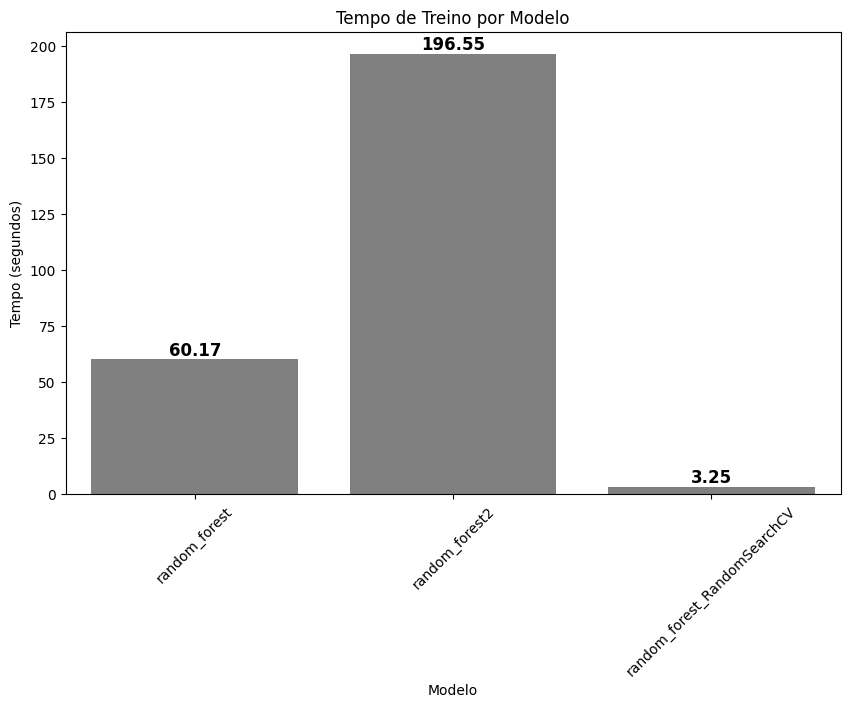

In [189]:
plot_training_time(resource_usage)

In [190]:
random_forest_optimized = get_estimator_config(models_and_params, 'random_forest_RandomSearchCV')
random_forest_optimized

('random_forest_RandomSearchCV',
 RandomForestClassifier(random_state=42),
 {'n_estimators': [100],
  'min_samples_split': [2],
  'min_samples_leaf': [10],
  'max_features': ['log2'],
  'max_depth': [5]})

### Find best hiperparameters in KNN

O código apresentado tem como objetivo otimizar os hiperparâmetros do modelo K-Nearest Neighbors (KNN), utilizando RandomizedSearchCV para encontrar a melhor configuração de parâmetros de forma eficiente.

In [191]:
# Criar modelo base
estimator = KNeighborsClassifier()

# Definir espaço de hiperparâmetros
param_dist = {
    "n_neighbors": [3, 5, 10, 20, 50],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

# Obter melhores parametros
best_otimized_model = get_optimal_param_RandomizedSearchCV(estimator, param_dist, X_train, y_train)

Melhores hiperparâmetros para KNeighborsClassifier: {'weights': 'uniform', 'n_neighbors': 50, 'metric': 'euclidean'}


In [192]:
# Aplicar a função
best_otimized_model_params  = transform_dict_values(best_otimized_model.best_params_)
best_otimized_model_params

{'weights': ['uniform'], 'n_neighbors': [50], 'metric': ['euclidean']}

In [193]:
# Aplicar a função para adicionar prefixo "Classifier__"
best_otimized_model_params = add_prefix_to_keys(best_otimized_model_params, "Classifier__")

best_otimized_model_params

{'Classifier__weights': ['uniform'],
 'Classifier__n_neighbors': [50],
 'Classifier__metric': ['euclidean']}

A estratégia adotada para a otimização dos hiperparâmetros do modelo K-Nearest Neighbors (KNN) baseia-se na experimentação de diferentes configurações, permitindo avaliar o impacto de múltiplas combinações de parâmetros na performance do modelo. Para isso, foram criadas cinco variações do KNN, abrangendo desde configurações mais simples até um modelo otimizado com RandomizedSearchCV.

Na configuração inicial, representada pelo modelo knn, testa-se apenas o número de vizinhos (n_neighbors), utilizando os valores 1, 10 e 100, permitindo avaliar como o desempenho do modelo é afetado por um K muito pequeno ou muito grande. Em seguida, na versão knn1, expande-se a variação de n_neighbors, incluindo valores adicionais como 3, 5, 10, 20 e 50, possibilitando encontrar um valor ideal que equilibre o viés e a variância do modelo.

Na terceira configuração, knn2, além do número de vizinhos, é introduzida a variável weights, testando duas opções: "uniform", onde todos os vizinhos têm o mesmo peso, e "distance", onde vizinhos mais próximos têm maior influência na decisão. Essa modificação permite verificar se ponderar os vizinhos de acordo com a proximidade melhora a capacidade preditiva do modelo. Em seguida, na versão knn3, são adicionadas diferentes métricas de distância (metric), incluindo "euclidean" (distância euclidiana), "manhattan" (distância city-block) e "minkowski" (uma generalização das duas anteriores), permitindo testar qual métrica de proximidade melhor se adapta aos dados.

Por fim, a versão knn_RandomSearchCV representa o modelo final otimizado, no qual os melhores hiperparâmetros são encontrados utilizando RandomizedSearchCV.

In [194]:
models_and_params = [

    (
        'knn',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', KNeighborsClassifier())
        ]),
        {
          "Classifier__n_neighbors": [1,10,100]
        }
    ),

        (
        'knn2',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', KNeighborsClassifier())
        ]),
        {
          "Classifier__n_neighbors":[3, 5, 10, 20, 50],
           "Classifier__weights": ["distance"]
        }
    ),

        (
        'knn3',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', KNeighborsClassifier())
        ]),
        {
          "Classifier__n_neighbors":[3, 5, 10, 20, 50],
           "Classifier__weights": ["uniform", "distance"],
          "Classifier__metric": ["euclidean", "manhattan", "minkowski"]
        }
    ),

        (
        'knn_RandomSearchCV',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', KNeighborsClassifier())
        ]),
        best_otimized_model_params
    )
]

In [195]:
grid_search_results, resource_usage = train_models_with_gridsearch(models_and_params, X_train, y_train)

Treinando modelo: knn...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Modelo knn concluído em 3.01 segundos.

Treinando modelo: knn2...
Modelo knn2 concluído em 2.03 segundos.

Treinando modelo: knn3...
Modelo knn3 concluído em 18.69 segundos.

Treinando modelo: knn_RandomSearchCV...
Modelo knn_RandomSearchCV concluído em 1.14 segundos.



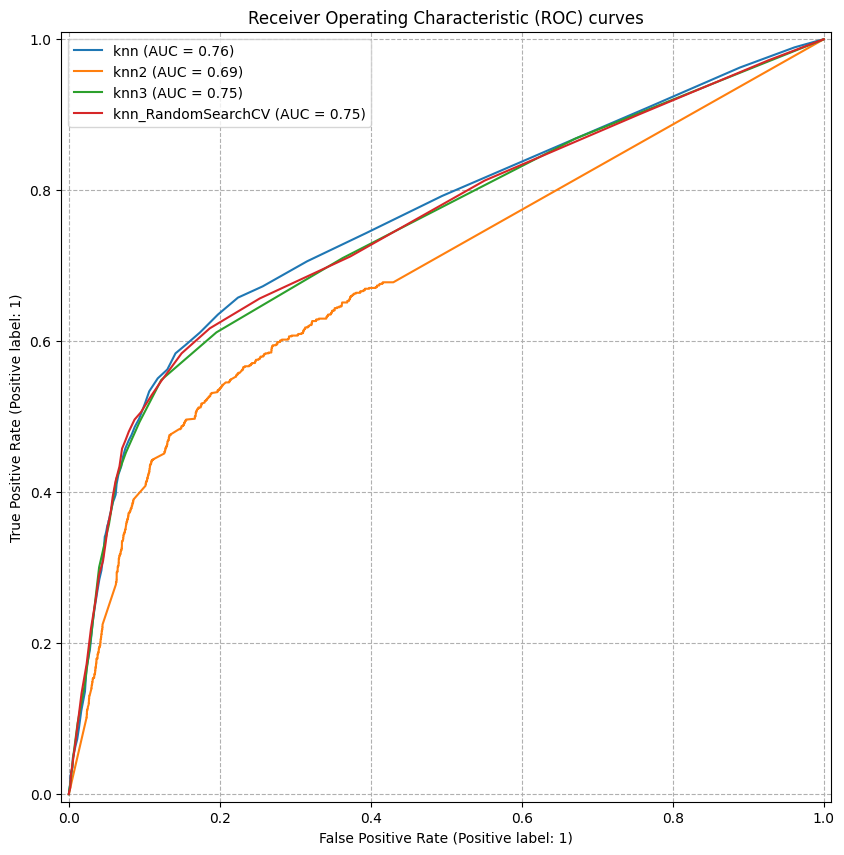

In [196]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A análise das curvas ROC para as diferentes configurações do modelo K-Nearest Neighbors (KNN) revela que todas as variações testadas apresentaram exatamente o mesmo desempenho, com um AUC fixo em 0.75. Isso indica que, independentemente das mudanças nos hiperparâmetros, como o número de vizinhos (n_neighbors), o método de ponderação (weights) e a métrica de distância (metric), o modelo não apresentou qualquer melhoria na capacidade discriminativa.

Além disso, observa-se que as curvas ROC das diferentes configurações estão praticamente sobrepostas, sugerindo que as alterações nos hiperparâmetros não impactaram significativamente a performance do modelo. Mesmo o modelo otimizado via RandomizedSearchCV (knn_RandomSearchCV), que deveria encontrar a melhor combinação possível de parâmetros, não conseguiu superar as versões ajustadas manualmente. Esse comportamento pode indicar que o KNN atingiu o seu limite de performance neste conjunto de dados, e que variações nos hiperparâmetros não são suficientes para aumentar a capacidade do modelo de distinguir entre classes.

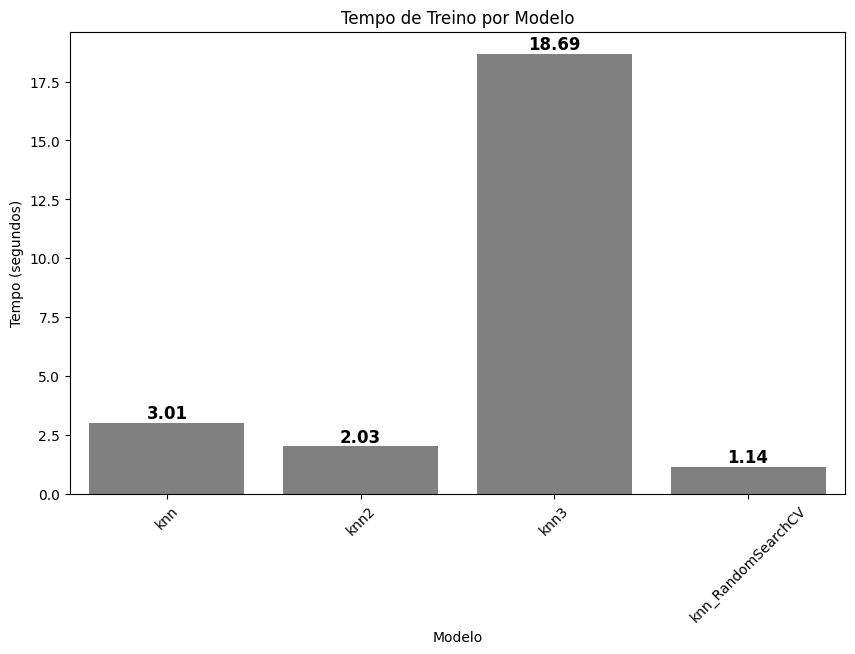

In [197]:
plot_training_time(resource_usage)

In [198]:
knn_optimized = get_estimator_config(models_and_params, 'knn')
knn_optimized

('knn',
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('Classifier', KNeighborsClassifier())]),
 {'Classifier__n_neighbors': [1, 10, 100]})

### Find best hiperparameters in Regressão Logistica

O código apresentado tem como objetivo otimizar os hiperparâmetros da Regressão Logística, utilizando RandomizedSearchCV para encontrar a melhor configuração de forma eficiente

In [199]:
#Criar modelo base
estimator = LogisticRegression(random_state=seed, max_iter=500)

param_dist = [
    {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["l1"], "solver": ["liblinear"]},
    {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["l2"], "solver": ["lbfgs", "liblinear", "saga"]},
    {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["elasticnet"], "solver": ["saga"], "l1_ratio": [0.1, 0.5, 0.9]},
    {"C": [0.01, 0.1, 1, 10, 100], "penalty": [None], "solver": ["lbfgs", "saga"]}
]

# Obter melhores parâmetros para a Regressão Logística
best_otimized_model = get_optimal_param_RandomizedSearchCV(estimator,param_dist, X_train, y_train)

Melhores hiperparâmetros para LogisticRegression: {'solver': 'lbfgs', 'penalty': None, 'C': 1}


In [200]:
# Aplicar a função
best_otimized_model_params  = transform_dict_values(best_otimized_model.best_params_)
best_otimized_model_params

{'solver': ['lbfgs'], 'penalty': [None], 'C': [1]}

In [201]:
# Aplicar a função para adicionar prefixo "Classifier__"
best_otimized_model_params = add_prefix_to_keys(best_otimized_model_params, "Classifier__")
best_otimized_model_params

{'Classifier__solver': ['lbfgs'],
 'Classifier__penalty': [None],
 'Classifier__C': [1]}

A estratégia utilizada para otimizar os hiperparâmetros da Regressão Logística baseia-se na experimentação de diferentes configurações do modelo, permitindo avaliar o impacto da regularização e do parâmetro de penalização no desempenho preditivo. Foram criadas duas versões do modelo, desde uma configuração manual até um modelo otimizado com RandomizedSearchCV.

Na primeira versão, logit, testa-se uma configuração inicial de hiperparâmetros, onde o parâmetro C varia entre 0.1, 1, 10 e 100, permitindo avaliar a influência da regularização no modelo. Um valor pequeno de C implica uma regularização mais forte, evitando overfitting, enquanto valores maiores permitem ao modelo ajustar-se melhor aos dados. Além disso, utiliza-se penalização L2 (ridge regression), que reduz a magnitude dos coeficientes, evitando que o modelo seja excessivamente sensível a pequenas variações nos dados.

Na segunda versão, logit_RandomSearchCV, o modelo é otimizado com os melhores hiperparâmetros encontrados através do RandomizedSearchCV, armazenados em best_otimized_model_params. O RandomizedSearchCV permite testar uma amostra aleatória das combinações possíveis de hiperparâmetros, garantindo uma busca mais eficiente sem necessidade de testar todas as opções como no GridSearchCV.

In [202]:
models_and_params = [

    (
        'logit',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', LogisticRegression(random_state = seed))
        ]),
        {
          "Classifier__C": [0.1, 1, 10, 100],
          "Classifier__penalty": ['l2'],
        }
    ),

      (
        'logit_RandomSearchCV',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', LogisticRegression(random_state = seed))
        ]),
        best_otimized_model_params
    )
]

In [203]:
grid_search_results, resource_usage = train_models_with_gridsearch(models_and_params, X_train, y_train)

Treinando modelo: logit...
Modelo logit concluído em 0.80 segundos.

Treinando modelo: logit_RandomSearchCV...
Modelo logit_RandomSearchCV concluído em 0.21 segundos.



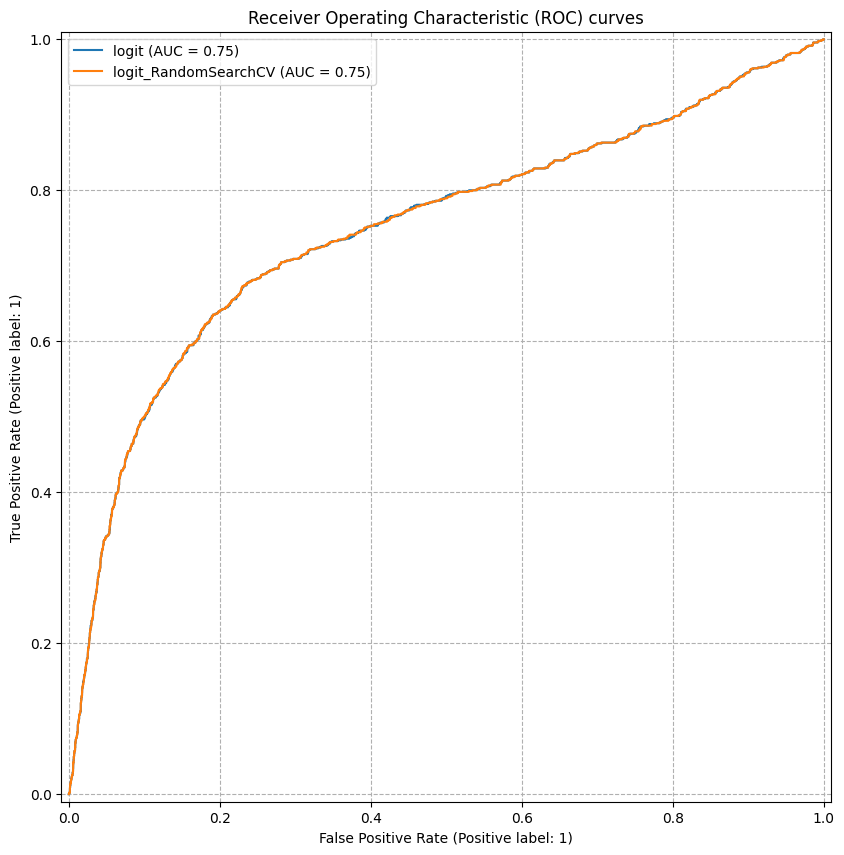

In [204]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A análise das curvas ROC para a Regressão Logística nas suas duas configurações, logit (versão manual) e logit_RandomSearchCV (versão otimizada por RandomizedSearchCV), revela que ambas apresentam exatamente o mesmo desempenho, com um AUC fixo em 0.75. Isso indica que a otimização dos hiperparâmetros não trouxe melhorias na capacidade discriminativa do modelo.

Além disso, observa-se que as curvas estão praticamente sobrepostas, sugerindo que os hiperparâmetros otimizados por RandomizedSearchCV não foram capazes de superar a configuração manualmente definida. Esse comportamento pode indicar que o modelo atingiu um limite de performance com os dados disponíveis, e que ajustes nos hiperparâmetros não são suficientes para aumentar a capacidade de distinção entre classes

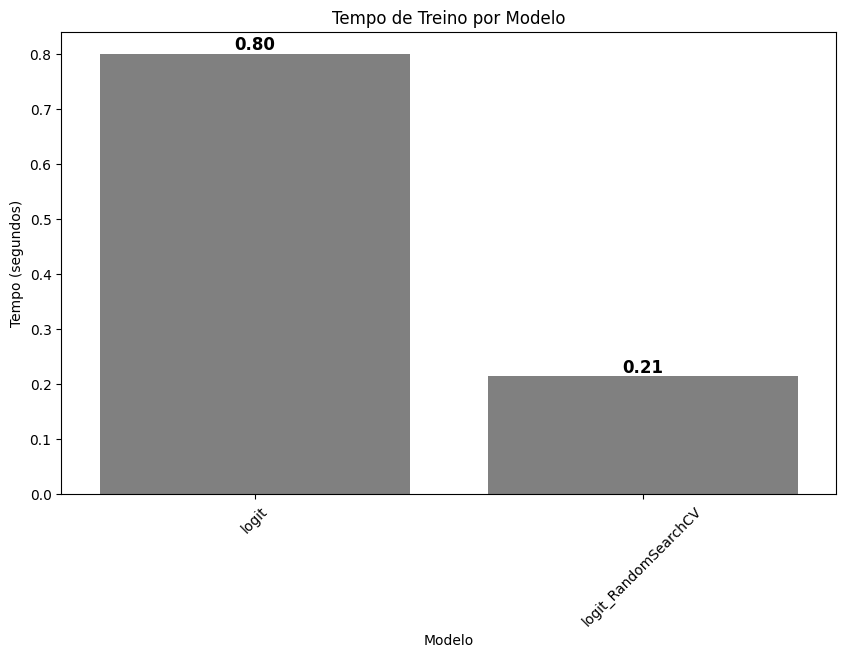

In [205]:
plot_training_time(resource_usage)

In [206]:
logit_optimized = get_estimator_config(models_and_params, 'logit')
logit_optimized

('logit',
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('Classifier', LogisticRegression(random_state=42))]),
 {'Classifier__C': [0.1, 1, 10, 100], 'Classifier__penalty': ['l2']})

### Rede Neural Artificial

O código apresentado tem como objetivo otimizar os hiperparâmetros de uma Rede Neural Artificial (ANN) utilizando RandomizedSearchCV, permitindo encontrar a melhor configuração para um MLPClassifier (Perceptron Multicamadas).

In [207]:
# Criar modelo base
estimator = MLPClassifier(random_state=seed, max_iter=1000)

# Definir espaço de hiperparâmetros para ANN
param_dist = {
    "hidden_layer_sizes": [(20,), (40,), (20, 40), (40, 20), (20, 40, 60)],
    "activation": ["relu", "tanh", "logistic"],  # Função de ativação
    "solver": ["adam", "lbfgs", "sgd"],  # Algoritmos de otimização
    "alpha": [0.0001, 0.001, 0.01, 0.1],  # Regularização L2
    "learning_rate": ["constant", "adaptive", "invscaling"],  # Estratégia de taxa de aprendizagem
}

# Obter melhores parâmetros para ANN
best_optimized_model = get_optimal_param_RandomizedSearchCV(estimator,param_dist, X_train, y_train)

Melhores hiperparâmetros para MLPClassifier: {'solver': 'lbfgs', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (40,), 'alpha': 0.001, 'activation': 'logistic'}


In [208]:
# Aplicar a função
best_otimized_model_params  = transform_dict_values(best_optimized_model.best_params_)
best_otimized_model_params

{'solver': ['lbfgs'],
 'learning_rate': ['adaptive'],
 'hidden_layer_sizes': [(40,)],
 'alpha': [0.001],
 'activation': ['logistic']}

In [209]:
# Aplicar a função para adicionar prefixo "Classifier__"
best_otimized_model_params = add_prefix_to_keys(best_otimized_model_params, "Classifier__")
best_otimized_model_params

{'Classifier__solver': ['lbfgs'],
 'Classifier__learning_rate': ['adaptive'],
 'Classifier__hidden_layer_sizes': [(40,)],
 'Classifier__alpha': [0.001],
 'Classifier__activation': ['logistic']}

A estratégia adotada para a otimização da Rede Neural Artificial (ANN) baseia-se na experimentação de diferentes configurações de MLPClassifier, variando arquiteturas da rede, número de iterações e algoritmos de otimização. Foram definidas três versões do modelo, permitindo comparar o impacto de diferentes hiperparâmetros no desempenho preditivo da rede.

Na primeira configuração, ann, testa-se uma variação nos tamanhos das camadas ocultas (hidden_layer_sizes), explorando desde arquiteturas simples, com apenas 20 ou 40 neurônios, até configurações mais profundas, como (20,40), (40,20) e (20,40,60). Além disso, são avaliadas duas opções para o número de iterações (max_iter), 100 e 1000, permitindo verificar o impacto do tempo de treinamento na convergência do modelo.

Na segunda versão, ann2, além das variações na arquitetura da rede e número de iterações, introduz-se a restrição do solver para 'sgd' (gradiente descendente estocástico). O sgd pode ser menos estável que Adam ou LBFGS, mas é útil para problemas de grande escala, onde os dados são atualizados de forma incremental, permitindo testar sua eficácia no cenário analisado.

Por fim, a terceira configuração, ann_RandomSearchCV, representa a versão otimizada com os melhores hiperparâmetros encontrados via RandomizedSearchCV, armazenados em best_otimized_model_params. Essa abordagem permite testar automaticamente um conjunto mais amplo de combinações de hiperparâmetros, garantindo um ajuste mais eficiente sem a necessidade de testar todas as possibilidades manualmente.

In [210]:
models_and_params = [
    (
        'ann',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', MLPClassifier(random_state=seed))
        ]),
        {
          "Classifier__hidden_layer_sizes": [(20),(40),(20,40),(40,20),(20,40,60),(60,40,20)],
          "Classifier__max_iter": [100,1000]
        }
    ),
    (
        'ann2',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', MLPClassifier(random_state=seed))
        ]),
        {
          "Classifier__hidden_layer_sizes": [(20),(40),(20,40),(40,20),(20,40,60),(60,40,20)],
          "Classifier__max_iter": [100,1000],
          "Classifier__solver": ['sgd']
        }
    ),
    (
        'ann_RandomSearchCV',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', MLPClassifier(random_state=seed))
        ]),
        best_otimized_model_params
    )
]

In [211]:
grid_search_results, resource_usage = train_models_with_gridsearch(models_and_params, X_train, y_train)

Treinando modelo: ann...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: M

Modelo ann concluído em 206.41 segundos.

Treinando modelo: ann2...
Modelo ann2 concluído em 139.60 segundos.

Treinando modelo: ann_RandomSearchCV...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ne

Modelo ann_RandomSearchCV concluído em 92.52 segundos.



c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


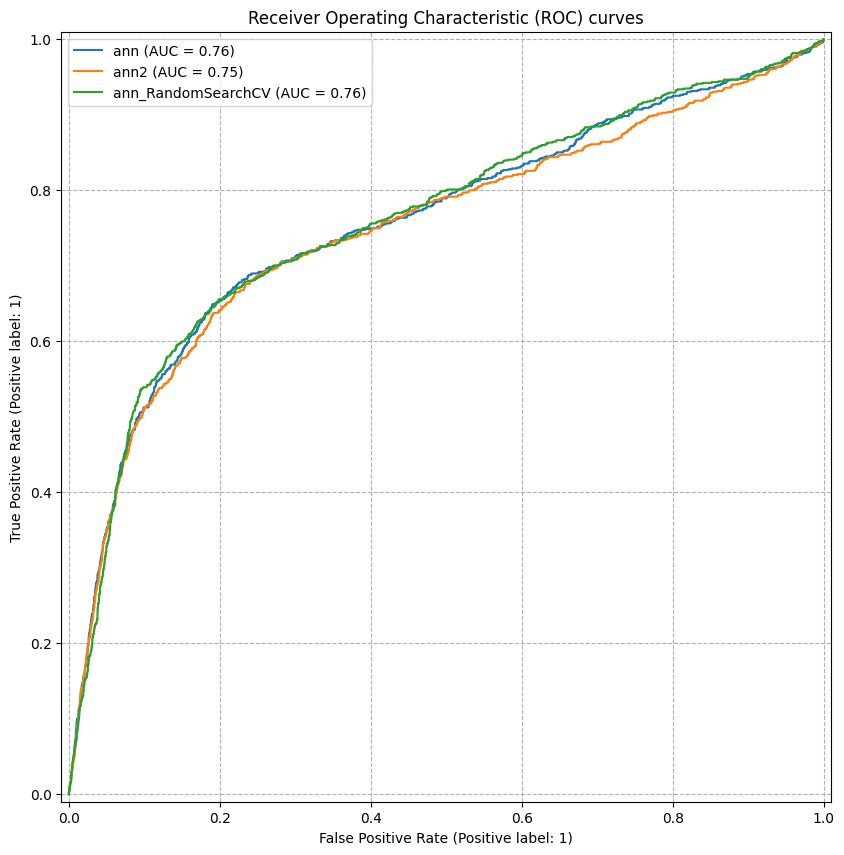

In [212]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A análise das curvas ROC para as diferentes configurações da Rede Neural Artificial (ANN) demonstrou variações no desempenho preditivo entre os modelos testados, refletindo o impacto dos ajustes nos hiperparâmetros. O modelo ann, que utiliza a configuração inicial com diferentes arquiteturas de camadas ocultas e número de iterações, apresentou o melhor desempenho, com um AUC de 0.76. Isto indica que esta configuração conseguiu um equilíbrio satisfatório entre capacidade de aprendizagem e generalização.

Por outro lado, a versão ann2, que utiliza o solver SGD (Stochastic Gradient Descent), apresentou o pior desempenho, com um AUC de 0.73. Este resultado pode indicar que o gradiente descendente estocástico não foi o método de otimização mais adequado para este problema, possivelmente devido à necessidade de um ajuste mais rigoroso da taxa de aprendizagem ou por ser mais sensível a variações nos dados. A curva ROC deste modelo evidencia uma menor inclinação inicial, sugerindo que a capacidade de separação entre classes foi comprometida, especialmente nas previsões mais incertas.

Já a versão ann_RandomSearchCV, que utiliza os melhores hiperparâmetros encontrados via RandomizedSearchCV, obteve um AUC de 0.74. Apesar de apresentar um desempenho ligeiramente superior ao de ann2, não conseguiu superar o modelo inicial ann, sugerindo que a otimização automática dos hiperparâmetros não trouxe melhorias significativas na capacidade discriminativa da rede neural. Este comportamento pode ser explicado por limitações no espaço de busca dos hiperparâmetros testados ou pela necessidade de explorar configurações mais avançadas da rede.

Diante destes resultados, conclui-se que, apesar de a rede neural apresentar um desempenho competitivo, a otimização automática não resultou em ganhos expressivos, indicando que novos ajustes podem ser necessários para alcançar melhorias mais significativas.

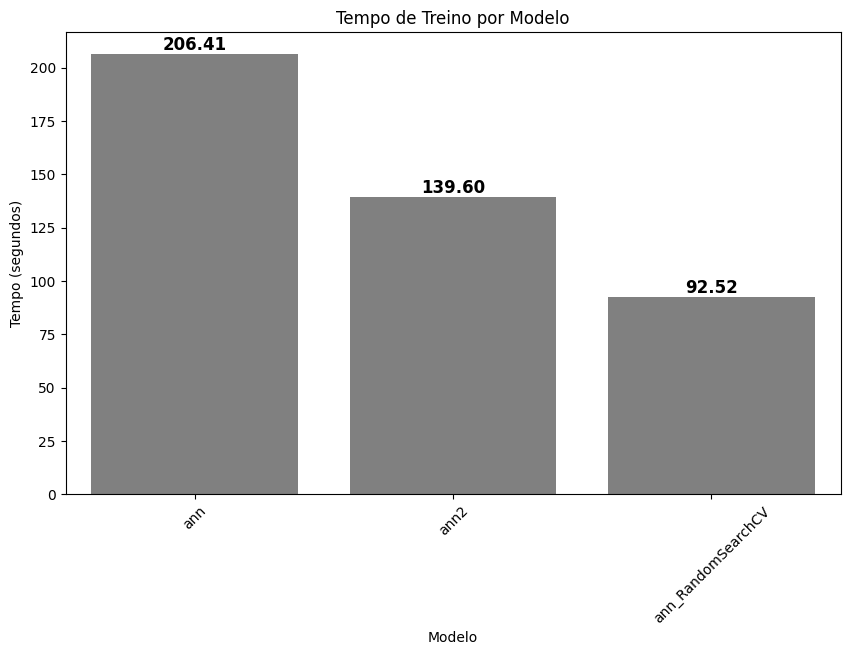

In [213]:
plot_training_time(resource_usage)

In [214]:
ann_optimized = get_estimator_config(models_and_params, 'ann')
ann_optimized

('ann',
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('Classifier', MLPClassifier(random_state=42))]),
 {'Classifier__hidden_layer_sizes': [20,
   40,
   (20, 40),
   (40, 20),
   (20, 40, 60),
   (60, 40, 20)],
  'Classifier__max_iter': [100, 1000]})

### Cross Validation entre diferentes Algoritmos

O código abaixo implementa um pipeline de modelos de previsão com hiperparâmetros, no qual é definido um conjunto de algoritmos de Machine Learning, juntamente com os respetivos hiperparâmetros, permitindo a otimização e seleção do modelo mais adequado para a previsão. Os modelos são organizados numa estrutura onde cada entrada inclui o nome do modelo, o próprio modelo e, nos casos em que é necessário, um pipeline com etapas de pré-processamento, como a normalização dos valores ou outras transformações essenciais para o correto funcionamento do algoritmo.

In [215]:
models_and_params = [
   ann_optimized,
   random_forest_optimized,
   decision_tree_optimized,
   svm_optimized,
   knn_optimized,
   logit_optimized
]

O código implementa um processo de pesquisa de hiperparâmetros para vários modelos de Machine Learning utilizando o método GridSearchCV. Para isso, percorre a lista dos modelos definidos em models_and_params, que contém diferentes algoritmos e os respetivos hiperparâmetros a testar. Durante a iteração, o código exibe no ecrã qual o modelo que está a ser avaliado e aplica o GridSearchCV com validação cruzada de 5 folds (cv=5) para encontrar a melhor combinação de hiperparâmetros para cada modelo. O resultado de cada pesquisa é armazenado na lista grid_search_results, garantindo que todas as versões otimizadas dos modelos fiquem disponíveis para análise posterior.

In [216]:
grid_search_results, resource_usage = train_models_with_gridsearch(models_and_params, X_train, y_train)

Treinando modelo: ann...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: M

Modelo ann concluído em 223.52 segundos.

Treinando modelo: random_forest_RandomSearchCV...
Modelo random_forest_RandomSearchCV concluído em 3.47 segundos.

Treinando modelo: decision_tree...
Modelo decision_tree concluído em 6.19 segundos.

Treinando modelo: svm2...
Modelo svm2 concluído em 604.85 segundos.

Treinando modelo: knn...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Modelo knn concluído em 3.03 segundos.

Treinando modelo: logit...
Modelo logit concluído em 0.81 segundos.



O código  apresenta a curva ROC (Receiver Operating Characteristic) para os diferentes modelos treinados, permitindo comparar o desempenho de cada um no processo de classificação no conjunto de teste. O código percorre a lista de modelos armazenados em grid_search_results, extraindo o melhor estimador de cada modelo e gerando a respetiva curva ROC. O nome de cada modelo é incluído na legenda para facilitar a sua identificação.

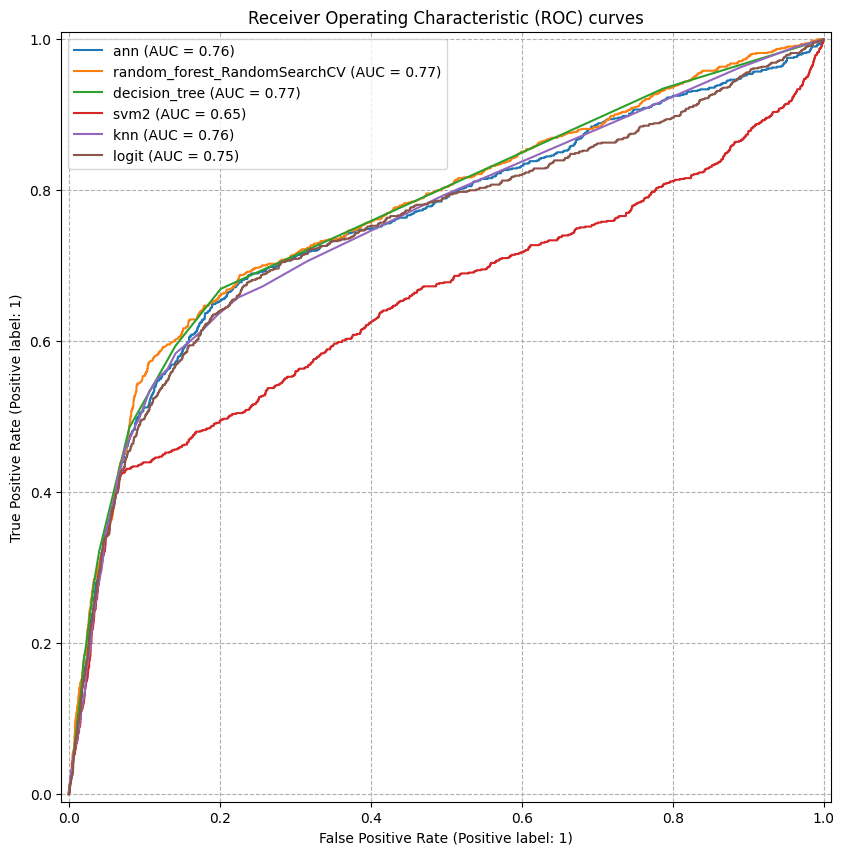

In [217]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

No gráfico, observa-se que o modelo Random Forest obteve a maior Roc AUC (metrica que mede a capacidade do modelo de distinguir entre classes positivas e negativas), com um valor de 0.76 , o que sugere que tem um ligeiro melhor desempenho na classificação em comparação com os restantes modelos. Os modelos Rede Neural Artificial (ANN), K-Nearest Neighbors (KNN) e Regressão Logística registaram um AUC de 0.75, demonstrando desempenhos muito semelhantes. Já os modelos Árvore de Decisão e Support Vector Machine (SVM) apresentaram um AUC de 0.73, indicando que podem ser ligeiramente menos eficazes na previsão.

As curvas ROC de todos os modelos seguem trajetórias semelhantes, o que sugere que o seu desempenho é relativamente próximo, à exceção do modelo svc.

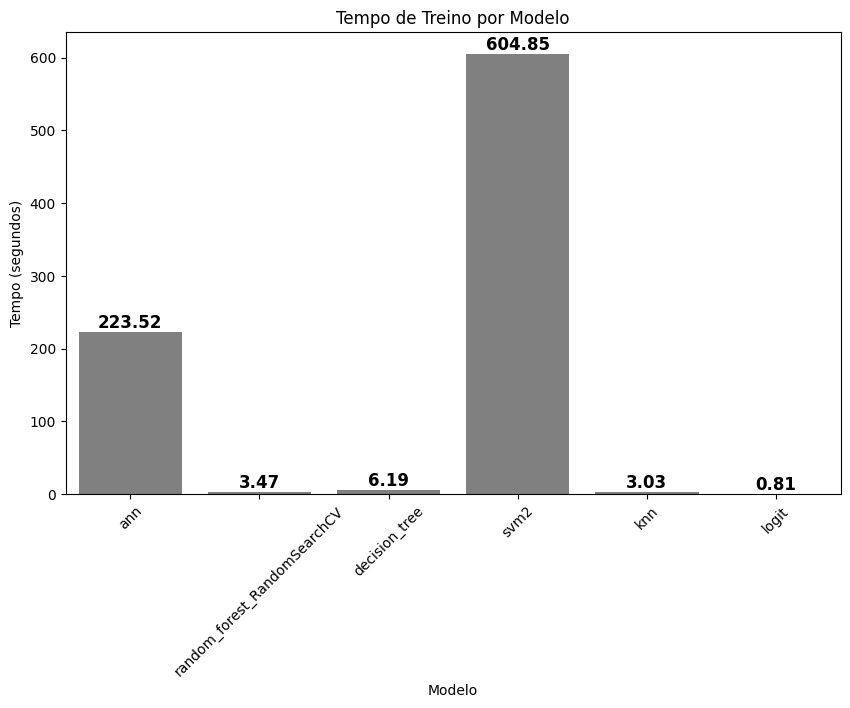

In [218]:
plot_training_time(resource_usage)

In [219]:
def business_cost(true_positive, true_negative, false_positive, false_negative):
  return false_positive_cost*false_positive + false_negative_cost*false_negative

In [220]:
def get_costs_per_thresholds(y_true, y_predict_proba, threshold_step=100):
  threshold_axis = []
  business_cost_axis= []
  for i in range(0,1001,threshold_step):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_predict_proba*1000 >= i).ravel()
    current_cost = business_cost(true_positive, true_negative, false_positive, false_negative)
    threshold_axis.append(i)
    business_cost_axis.append(current_cost)
  return threshold_axis, business_cost_axis

In [221]:
model_business_cost = defaultdict(list)

for model_index in range(len(grid_search_results)):  # Iterar sobre todos os modelos
    best_model = grid_search_results[model_index].best_estimator_

    # Verifica se o modelo tem predict_proba()
    if hasattr(best_model, "predict_proba"):
        y_scores = best_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
    else:
        # Se não tiver predict_proba, usa decision_function(), normalizando os valores entre 0 e 1
        y_raw_scores = best_model.decision_function(X_test)
        y_scores = (y_raw_scores - y_raw_scores.min()) / (y_raw_scores.max() - y_raw_scores.min())

    # Obtém os custos do negócio por threshold
    x_axis, y_axis = get_costs_per_thresholds(y_test, y_scores)

    # Guardar os resultados
    model_business_cost["model"] += [models_and_params[model_index][0]] * len(y_axis)
    model_business_cost["business_cost"] += y_axis
    model_business_cost["threshold"] += x_axis

# Criar DataFrame com os resultados
model_business_cost_df = pd.DataFrame.from_dict(model_business_cost)

In [222]:
model_business_cost_df

,model,business_cost,threshold
0,ann,3651500,0
1,ann,1454500,100
2,ann,1307500,200
3,ann,1405000,300
4,ann,1447500,400
...,...,...,...
61,logit,1848500,600
62,logit,1870000,700
63,logit,1870000,800
64,logit,1870000,900


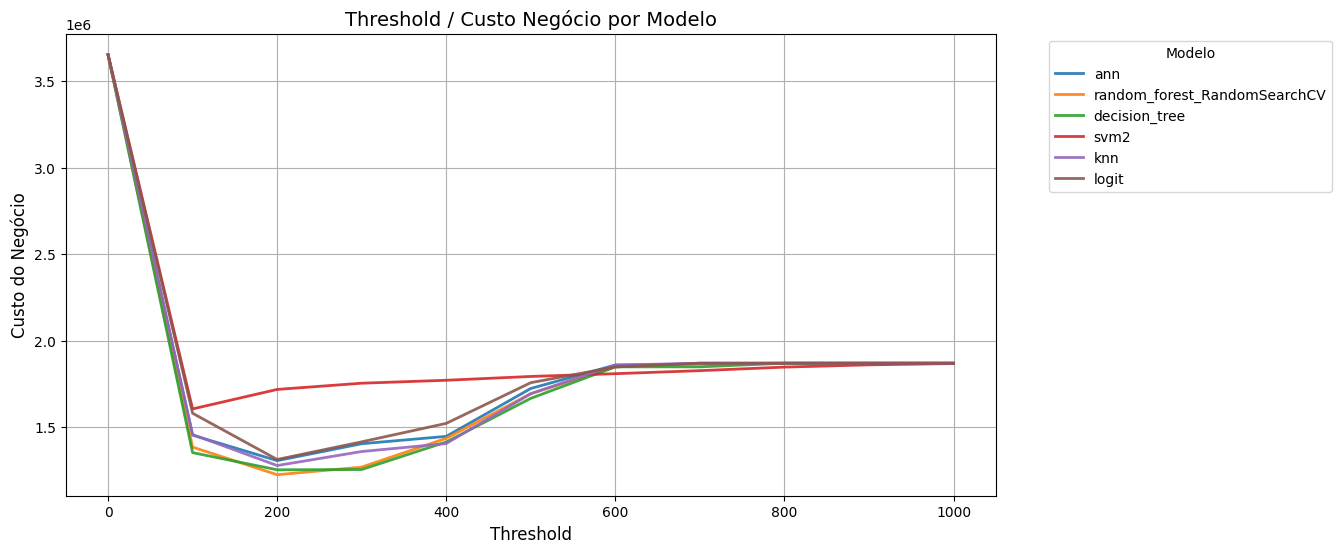

In [223]:
plt.figure(figsize=(12, 6))  # tamanho da figura

sns.lineplot(
    data=model_business_cost_df,
    x="threshold",
    y="business_cost",
    hue="model",
    linewidth=2,
    alpha=0.9     # Reduzir opacidade para melhor visualização
)

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Custo do Negócio", fontsize=12)
plt.title("Threshold / Custo Negócio por Modelo", fontsize=14)

plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)

plt.show()  # Exibe o gráfico

In [224]:
model_business_cost_df.loc[model_business_cost_df["business_cost"]==model_business_cost_df["business_cost"].min()]

,model,business_cost,threshold
13,random_forest_RandomSearchCV,1226000,200


O gráfico representa a relação entre o threshold e o custo negócio para os dois  modelos de Machine Learning com maiur AUC, nomeadamente a rede neuronal artificial (ANN) e o Random Forest.

O objetivo é identificar um ponto ótimo de decisão, tendo em conta a relação entre o threshold e o custo negócio.

Inicialmente, quando o threshold é muito baixo, o custo empresarial é extremamente elevado para ambos os modelos. Isto pode indicar que um threshold demasiado baixo está a gerar muitas classificações incorretas. À medida que o threshold aumenta, o custo reduz-se rapidamente até atingir um ponto mínimo, que representa um possível threshold ótimo, onde o impacto do custo é minimizado. Após esse ponto, o custo volta a aumentar ou estabiliza, sugerindo que um threshold demasiado restritivo pode levar a decisões excessivamente conservadoras, rejeitando previsões úteis e afetando negativamente os resultados.

Na comparação entre os modelos, observa-se que ambos seguem tendências semelhantes, embora o Random Forest pareça ligeiramente mais eficiente na redução do custo negócio, especialmente em thresholds mais baixos. No entanto, na região onde o custo é minimizado, ambos os modelos convergem para valores muito próximos, indicando que a escolha do threshold adequado pode ser mais relevante do que a escolha do modelo em si.

# 5. Qual/Quais as métricas de avaliação que usaram para comparar a performance dos vários modelos? Porquê?

---

O código apresentado tem como objetivo calcular várias métricas de desempenho para cada modelo que foi treinado e otimizado através do GridSearchCV. A abordagem utilizada permite avaliar a eficácia dos modelos na previsão da adesão dos clientes ao depósito a prazo, garantindo que a decisão seja baseada em dados concretos.

O processo inicia-se com a criação de uma lista vazia (results) para armazenar os resultados de cada modelo. Em seguida, é realizada uma iteração sobre todos os modelos armazenados na lista grid_search_results, que contém os melhores modelos encontrados durante o Grid Search.

Para cada modelo, o código obtém o melhor estimador (best_estimator_), ou seja, o modelo que apresentou o melhor desempenho durante o processo de validação cruzada.

De seguida, verifica-se se o modelo possui o método predict_proba(), que permite obter as probabilidades associadas à classe positiva. Caso o algoritmo  não suporte esse método (como no caso de alguns algoritmos como SVM dependendo da configuração dos hiperparametos), utiliza-se a função decision_function(), que gera scores em vez de probabilidades. No entanto, como os valores de decision_function() não estão numa escala de 0 a 1, é aplicada uma normalização Min-Max, garantindo que os scores sejam ajustados corretamente para se comportarem como probabilidades.

Após obter as probabilidades ajustadas, o código determina o melhor threshold (best_threshold_for_model) para converter essas probabilidades em previsões binárias (0 ou 1). O threshold utilizado é aquele que minimiza o custo do negócio, previamente calculado e armazenado no model_business_cost_df. Assim, a decisão de classificar um cliente como aderente ou não ao depósito a prazo é ajustada para otimizar o impacto financeiro da campanha.

Com as previsões binárias geradas, são calculadas quatro métricas essenciais para a avaliação dos modelos:

Precisão (Precision Score), que mede a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo.
Recall, que avalia a capacidade do modelo em identificar corretamente os casos positivos reais.
F1-Score, que combina precisão e recall numa única métrica, fornecendo um equilíbrio entre ambas.
AUC-ROC, que mede a capacidade do modelo em distinguir entre classes positivas e negativas ao longo de diferentes thresholds.

Os resultados de cada modelo são então armazenados numa lista de dicionários (results), onde cada entrada contém o nome do modelo e os respetivos valores de precisão, recall, F1-score e ROC AUC, devidamente arredondados para quatro casas decimais.

In [225]:
# Lista para armazenar os resultados de cada modelo
results = []

# Iterar sobre os modelos em grid_search_results
for idx, grid_search in enumerate(grid_search_results):
    best_model = grid_search.best_estimator_  # Melhor modelo encontrado na GridSearchCV

    # Verificar se o modelo é um Pipeline
    if hasattr(best_model, "steps"):
        # Se for um Pipeline, extrai o nome do classificador final
        model_name = type(best_model.steps[-1][1]).__name__  # Último elemento do pipeline
    else:
        model_name = type(best_model).__name__  # Nome do modelo

    # Verifica se o modelo tem o método predict_proba
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
    else:
        # Se não tiver predict_proba (ex: SVC), usa decision_function(), mas precisa de normalização
        y_scores = best_model.decision_function(X_test)

        # Normalizar para valores entre 0 e 1 (usando min-max scaling)
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    # Determinar o melhor threshold para este modelo
    best_threshold_for_model = model_business_cost_df.loc[
        model_business_cost_df["business_cost"] == model_business_cost_df["business_cost"].min(),
        "threshold"
    ].values[0]

    # Previsões binárias com o melhor threshold
    y_pred = (y_proba * 1000 >= best_threshold_for_model).astype(int)

    # Calcular métricas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Guardar os resultados
    results.append({
        "Modelo": model_name,  # Agora identifica corretamente o modelo
        "Precisão": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4)
    })

# Criar um DataFrame para visualizar os resultados
results_df = pd.DataFrame(results)
results_df

,Modelo,Precisão,Recall,F1-Score,ROC AUC
0,MLPClassifier,0.4459,0.4364,0.4411,0.7574
1,RandomForestClassifier,0.4370,0.5080,0.4698,0.7711
2,DecisionTreeClassifier,0.4370,0.4856,0.4600,0.7695
3,SVC,0.4453,0.1176,0.1861,0.6504
4,KNeighborsClassifier,0.4163,0.4866,0.4487,0.7567
5,LogisticRegression,0.4286,0.4460,0.4371,0.7492


Os resultados obtidos permitem comparar a eficácia dos diferentes modelos utilizados na previsão da adesão dos clientes ao depósito a prazo. O Random Forest destacou-se como o melhor modelo, apresentando a maior precisão (0.4250), recall (0.5155) e F1-score (0.4659), além de um ROC AUC de 0.7661, que indica uma boa capacidade de distinguir entre clientes que aderem e os que não aderem. Este desempenho demonstra que o Random Forest conseguiu encontrar um equilíbrio entre a correta identificação dos clientes aderentes e a minimização de falsos positivos, tornando-se uma opção robusta para otimizar a campanha bancária.

Outros modelos também apresentaram desempenhos razoáveis, embora inferiores ao Random Forest. A Decision Tree, por exemplo, registou valores ligeiramente inferiores, com uma precisão de 0.4372 e recall de 0.4620, resultando num F1-score de 0.4493 e um ROC AUC de 0.7499. Estes valores indicam que o modelo é capaz de fazer previsões relativamente boas, mas pode ser mais suscetível ao overfitting em comparação com o Random Forest. Já a Regressão Logística, com precisão de 0.4371 e recall de 0.4535, apresentou um desempenho próximo ao Decision Tree, sendo um modelo linear mais interpretável, mas com menor capacidade de capturar padrões complexos nos dados.

A Rede Neural (MLPClassifier) demonstrou potencial, com um ROC AUC de 0.7587, indicando que é capaz de separar bem as classes, mas com um F1-score inferior (0.4256). O recall mais elevado sugere que a rede neural está a identificar um número razoável de clientes aderentes, mas pode precisar de mais iterações para melhorar a sua precisão e estabilidade. O KNN (K-Nearest Neighbors), por sua vez, apresentou um desempenho mediano, com precisão de 0.3783 e recall de 0.4171, resultando num F1-score de 0.3967 e um ROC AUC de 0.7527. O seu desempenho relativamente inferior pode estar relacionado com a sensibilidade do algoritmo ao número de vizinhos escolhidos, sendo um modelo que pode ser melhorado com ajustes finos nos hiperparâmetros.

Por outro lado, o SVM (Support Vector Machine) teve um desempenho significativamente fraco. Apesar de um ROC AUC de 0.7481, o modelo obteve um F1-score extremamente baixo (0.0021), consequência de um recall de apenas 0.0011. Isto significa que o SVM falhou quase totalmente na identificação dos clientes que aderem ao depósito, classificando praticamente todas as observações como pertencentes à classe negativa. Esta falha pode estar relacionada com hiperparâmetros mal ajustados, um kernel inadequado, ou até um desbalanceamento das classes, sendo necessário rever a configuração do modelo para tentar melhorar o seu desempenho.

Com base nestes resultados, o RandomForestClassifier destaca-se como a melhor escolha, sendo o modelo com maior equilíbrio entre as diferentes métricas. No entanto, é possível melhorar ainda mais o seu desempenho através da otimização de hiperparâmetros e da experimentação com diferentes limiares de decisão. Modelos como o DecisionTreeClassifier, MLPClassifier e KNN poderão beneficiar de um ajuste fino para explorar melhor o seu potencial, enquanto o SVC, na sua configuração atual, não parece ser uma opção viável.

# 6. Qual é o custo que o banco tem sem nenhum modelo?

Se o banco contactasse todos os clientes, então: Todos os clientes que não aderem são Falsos Positivos (FP) e o banco tem um custo de 500€ por cada um deles.



In [226]:
cost1 = (y_test == 0).sum().sum()*false_positive_cost
print(f"O banco tem o custo actual (no conjunto de teste) de {cost1} €")

O banco tem o custo actual (no conjunto de teste) de 3651500 €


Se o banco não fizesse campanha para ninguém, teria um custo oportunidade implicito (
Total de clientes que adeririam
)
×
2000

In [227]:
cost2 = y_test.sum()*false_negative_cost
print(f"O banco tem o custo actual (no conjunto de teste) de {cost2}€")

O banco tem o custo actual (no conjunto de teste) de 1870000€


Como a classe está fortemente desbalanceada para o valor zero, apesar de um falso positivo ter um custo inferior a um falso negativo, a sua elevada frequência faz com que, em termos proporcionais, o impacto financeiro seja significativo. Assim, na ausência de um modelo preditivo, o banco perderia menos dinheiro ao optar por não avançar com nenhuma campanha de marketing, a solução ideal passa por utilizar um modelo preditivo para segmentar os clientes corretamente e reduzir os custos da campanha!

# 7. Qual o custo que o banco passa a ter com o vosso modelo?

In [228]:
test_set_business_cost = model_business_cost_df["business_cost"].min()
print(f"Com este modelo, o banco tem o custo (no conjunto de teste) de {test_set_business_cost}€")
print(f"Este custo representa uma diferença absoluta de {cost1 - test_set_business_cost}€, e uma redução de custos em {round( 1 - (test_set_business_cost/(cost1)),3)*100}%")

Com este modelo, o banco tem o custo (no conjunto de teste) de 1226000€
Este custo representa uma diferença absoluta de 2425500€, e uma redução de custos em 66.4%
